# Usage example on model of _Corynebacterium tuberculostearicum (high GC Gram+)_.
In this notebook we show how to use the Mass Charge Curation python package. As an example model we use a model of [_Corynebacterium tuberculostearicum (high GC Gram+)_, strain DSM 44922](https://www.ncbi.nlm.nih.gov/assembly/GCF_013408445.1/) created with [CarveMe Version 1.5.1](https://carveme.readthedocs.io/en/latest/index.html), which here is simply called _model.xml_.

If you are interested in a more verbose output you can uncomment the following line:

In [1]:
import logging; logging.basicConfig(format='%(levelname)s: %(filename)s %(lineno)d, %(funcName)s: %(message)s', level=logging.INFO) 

## Dependencies
First we will check if all dependencies of the curation package are fullfilled.

In [2]:
try: import numpy
except Exception as e: print("You seem to be missing numpy. You can usually install it via 'pip install numpy'"); raise e
try: import pandas
except Exception as e: print("You seem to be missing pandas. You can usually install it via 'pip install pandas'"); raise e
try: import requests
except Exception as e: print("You seem to be missing requests. You can usually install it via 'pip install requests'"); raise e
try: import matplotlib
except Exception as e: print("You seem to be missing matplotlib. You can usually install it via 'pip install matplotlib'"); raise e
try: import z3
except Exception as e: print("You seem to be missing z3 or the corresponding python bindings. See https://github.com/Z3Prover/z3 on how to install it."); raise e

Next we see if the Mass Charge Curation package is installed properly.

In [3]:
try: import MCC
except Exception as e: print("The mass charge curation package does not seem to be installed correctly. Make sure you have the correct python version installed and try running pip install -e ./.. in the folder of this notebook."); raise e

## Setting input path
We can use the package with different type of models. Depending on what else we intend to do with the model we can already read it in using libsbml or cobraPy or immediatly pass in the path of the model (This will cause the module to read it in itself using libsbml).

In [4]:
model = "model.xml"

# Alternatives:
# reading in the model beforehand using libsbml:
'''
import libsbml
reader = libsbml.SBMLReader()
document = reader.readSBML(model)
model = document.getModel()
'''
# reading in the model beforehand using cobraPy:
'''
import cobra
model = cobra.io.read_sbml_model(model)
'''
print(model)

model.xml


## Basic Model Information
First we can take a quick look at the model using the module ModelInterface class:

In [5]:
mi = MCC.ModelInterface(model)
print(f"The model has {len(mi.metabolites)} metabolites and {len(mi.reactions)} reactions.")
unbalanced_reactions = [r_id for r_id, r in mi.reactions.items() if (not r.is_balanced())]
print(f"There are {len(unbalanced_reactions)} unbalanced reactions with {len(mi.get_pseudo_reactions())} pseudo reactions.")

The model has 1019 metabolites and 1481 reactions.
There are 210 unbalanced reactions with 196 pseudo reactions.


## Curating Mass and Charge
We can now instantiate a curation class. There are different ways to use the package, depending how data should be gathered, how much curation has already been done and how much data is available offline.

We will first give an example of the most simple usage, downloading as many databases as possible and updating all [identifiers.org](https://identifiers.org/) identifiers we need for the package to work optimally. This will take significantly longer (**~ 15 Minutes**) than running the algorithm on an already annotated model, however it is important to use the most up-to-date identifiers if we want to include as much information as possible.

This will create a folder _/data_ in the current directory where all database information is downloaded to.

The arguments are as follows:
* **model**: Model we want to curate.
* **data_path**: Path to the directory containing database files. Defaults to _/data_. If the directory does not exist, it will be created. If a file cannot be found, we will try to download it. 
* **update_ids**: If this is set to _True_, we will first try to update all [identifiers.org](https://identifiers.org/) ids. This will take a while but is important to properly index the different databases. Defaults to _False_. 

**Note**: It is expected to see _No objective coefficients in model. Unclear what should be optimized_ warnings here, this poses no problem for this package.

In [6]:
balancer = MCC.MassChargeCuration(model = model, data_path = "./data", run_optimization = True, update_ids = True)

INFO: DataCollection.py 182, get_all_ids: 1/1019: M_10fthf_c
INFO: DataCollection.py 226, get_ids: Found new ids ['MNXM1102376'] in metanetx.chemical via id & name based search for M_10fthf_c
INFO: DataCollection.py 182, get_all_ids: 2/1019: M_12dgr140_c
INFO: DataCollection.py 226, get_ids: Found new ids ['MNXM2902'] in metanetx.chemical via id & name based search for M_12dgr140_c
INFO: DataCollection.py 182, get_all_ids: 3/1019: M_12dgr140_p
INFO: DataCollection.py 226, get_ids: Found new ids ['MNXM2902'] in metanetx.chemical via id & name based search for M_12dgr140_p
INFO: DataCollection.py 182, get_all_ids: 4/1019: M_12dgr141_c
INFO: DataCollection.py 275, get_ids: Found new id MNXM4940 in metanetx.chemical from ('bigg.metabolite', '12dgr141') for M_12dgr141_c
INFO: DataCollection.py 182, get_all_ids: 5/1019: M_12dgr141_p
INFO: DataCollection.py 275, get_ids: Found new id MNXM4940 in metanetx.chemical from ('bigg.metabolite', '12dgr141') for M_12dgr141_p
INFO: DataCollection.py 18

INFO: DataCollection.py 275, get_ids: Found new id MNXM3447 in metanetx.chemical from ('bigg.metabolite', '2agpe141') for M_2agpe141_p
INFO: DataCollection.py 182, get_all_ids: 36/1019: M_2agpe160_c
INFO: DataCollection.py 275, get_ids: Found new id MNXM34810 in metanetx.chemical from ('bigg.metabolite', '2agpe160') for M_2agpe160_c
INFO: DataCollection.py 182, get_all_ids: 37/1019: M_2agpe160_p
INFO: DataCollection.py 275, get_ids: Found new id MNXM34810 in metanetx.chemical from ('bigg.metabolite', '2agpe160') for M_2agpe160_p
INFO: DataCollection.py 182, get_all_ids: 38/1019: M_2agpe161_c
INFO: DataCollection.py 275, get_ids: Found new id MNXM3448 in metanetx.chemical from ('bigg.metabolite', '2agpe161') for M_2agpe161_c
INFO: DataCollection.py 182, get_all_ids: 39/1019: M_2agpe161_p
INFO: DataCollection.py 275, get_ids: Found new id MNXM3448 in metanetx.chemical from ('bigg.metabolite', '2agpe161') for M_2agpe161_p
INFO: DataCollection.py 182, get_all_ids: 40/1019: M_2agpg140_c
INF

INFO: DataCollection.py 275, get_ids: Found new id MNXM153 in metanetx.chemical from ('bigg.metabolite', '34hpp') for M_34hpp_c
INFO: DataCollection.py 182, get_all_ids: 70/1019: M_35dnta_c
INFO: DataCollection.py 226, get_ids: Found new ids ['MNXM1091744'] in metanetx.chemical via id & name based search for M_35dnta_c
INFO: DataCollection.py 182, get_all_ids: 71/1019: M_35dnta_e
INFO: DataCollection.py 226, get_ids: Found new ids ['MNXM1091744'] in metanetx.chemical via id & name based search for M_35dnta_e
INFO: DataCollection.py 182, get_all_ids: 72/1019: M_3c2hmp_c
INFO: DataCollection.py 226, get_ids: Found new ids ['MNXM741109'] in metanetx.chemical via id & name based search for M_3c2hmp_c
INFO: DataCollection.py 182, get_all_ids: 73/1019: M_3c3hmp_c
INFO: DataCollection.py 226, get_ids: Found new ids ['MNXM730929'] in metanetx.chemical via id & name based search for M_3c3hmp_c
INFO: DataCollection.py 182, get_all_ids: 74/1019: M_3c4mop_c
INFO: DataCollection.py 275, get_ids: Fo

INFO: DataCollection.py 182, get_all_ids: 100/1019: M_4c2me_c
INFO: DataCollection.py 226, get_ids: Found new ids ['MNXM730948'] in metanetx.chemical via id & name based search for M_4c2me_c
INFO: DataCollection.py 182, get_all_ids: 101/1019: M_4hadnt_c
INFO: DataCollection.py 226, get_ids: Found new ids ['MNXM1091955', 'MNXM1803'] in metanetx.chemical via id & name based search for M_4hadnt_c
INFO: DataCollection.py 182, get_all_ids: 102/1019: M_4hba_c
INFO: DataCollection.py 275, get_ids: Found new id MNXM107505 in metanetx.chemical from ('bigg.metabolite', '4hba') for M_4hba_c
INFO: DataCollection.py 182, get_all_ids: 103/1019: M_4hba_e
INFO: DataCollection.py 275, get_ids: Found new id MNXM107505 in metanetx.chemical from ('bigg.metabolite', '4hba') for M_4hba_e
INFO: DataCollection.py 182, get_all_ids: 104/1019: M_4hglusa_c
INFO: DataCollection.py 275, get_ids: Found new id MNXM2687 in metanetx.chemical from ('bigg.metabolite', '4hglusa') for M_4hglusa_c
INFO: DataCollection.py 18

INFO: DataCollection.py 182, get_all_ids: 136/1019: M_R_3h4atba_c
INFO: DataCollection.py 226, get_ids: Found new ids ['MNXM1092433'] in metanetx.chemical via id & name based search for M_R_3h4atba_c
INFO: DataCollection.py 182, get_all_ids: 137/1019: M_R_3h4atbcoa_c
INFO: DataCollection.py 226, get_ids: Found new ids ['MNXM1092434'] in metanetx.chemical via id & name based search for M_R_3h4atbcoa_c
INFO: DataCollection.py 182, get_all_ids: 138/1019: M_R_3h6atha_c
INFO: DataCollection.py 226, get_ids: Found new ids ['MNXM1092435'] in metanetx.chemical via id & name based search for M_R_3h6atha_c
INFO: DataCollection.py 182, get_all_ids: 139/1019: M_R_3h6athcoa_c
INFO: DataCollection.py 226, get_ids: Found new ids ['MNXM1092436'] in metanetx.chemical via id & name based search for M_R_3h6athcoa_c
INFO: DataCollection.py 182, get_all_ids: 140/1019: M_R_3hcddec5ecoa_c
INFO: DataCollection.py 275, get_ids: Found new id MNXM6020 in metanetx.chemical from ('bigg.metabolite', 'R_3hcddec5ecoa

INFO: DataCollection.py 182, get_all_ids: 175/1019: M_R_3hppta_c
INFO: DataCollection.py 226, get_ids: Found new ids ['MNXM1092463'] in metanetx.chemical via id & name based search for M_R_3hppta_c
INFO: DataCollection.py 182, get_all_ids: 176/1019: M_R_3hpptcoa_c
INFO: DataCollection.py 226, get_ids: Found new ids ['MNXM1092464'] in metanetx.chemical via id & name based search for M_R_3hpptcoa_c
INFO: DataCollection.py 182, get_all_ids: 177/1019: M_R_3hpt_c
INFO: DataCollection.py 226, get_ids: Found new ids ['MNXM1092465', 'MNXM36561'] in metanetx.chemical via id & name based search for M_R_3hpt_c
INFO: DataCollection.py 182, get_all_ids: 178/1019: M_R_3hptcoa_c
INFO: DataCollection.py 226, get_ids: Found new ids ['MNXM1092466'] in metanetx.chemical via id & name based search for M_R_3hptcoa_c
INFO: DataCollection.py 182, get_all_ids: 179/1019: M_R_3htd58coa_c
INFO: DataCollection.py 226, get_ids: Found new ids ['MNXM1092467'] in metanetx.chemical via id & name based search for M_R_3

INFO: DataCollection.py 182, get_all_ids: 212/1019: M_actp_c
INFO: DataCollection.py 275, get_ids: Found new id MNXM280 in metanetx.chemical from ('bigg.metabolite', 'actp') for M_actp_c
INFO: DataCollection.py 182, get_all_ids: 213/1019: M_acysbmn_c
INFO: DataCollection.py 226, get_ids: Found new ids ['MNXM7016'] in metanetx.chemical via id & name based search for M_acysbmn_c
INFO: DataCollection.py 182, get_all_ids: 214/1019: M_acysbmn_e
INFO: DataCollection.py 226, get_ids: Found new ids ['MNXM7016'] in metanetx.chemical via id & name based search for M_acysbmn_e
INFO: DataCollection.py 182, get_all_ids: 215/1019: M_ade_c
INFO: DataCollection.py 275, get_ids: Found new id MNXM168 in metanetx.chemical from ('bigg.metabolite', 'ade') for M_ade_c
INFO: DataCollection.py 182, get_all_ids: 216/1019: M_adhlam_c
INFO: DataCollection.py 182, get_all_ids: 217/1019: M_adn_c
INFO: DataCollection.py 182, get_all_ids: 218/1019: M_adp_c
INFO: DataCollection.py 226, get_ids: Found new ids ['MNXM40

INFO: DataCollection.py 182, get_all_ids: 249/1019: M_alahis_c
INFO: DataCollection.py 226, get_ids: Found new ids ['MNXM1092541'] in metanetx.chemical via id & name based search for M_alahis_c
INFO: DataCollection.py 182, get_all_ids: 250/1019: M_alahis_e
INFO: DataCollection.py 226, get_ids: Found new ids ['MNXM1092541'] in metanetx.chemical via id & name based search for M_alahis_e
INFO: DataCollection.py 182, get_all_ids: 251/1019: M_alahis_p
INFO: DataCollection.py 226, get_ids: Found new ids ['MNXM1092541'] in metanetx.chemical via id & name based search for M_alahis_p
INFO: DataCollection.py 182, get_all_ids: 252/1019: M_alaleu_c
INFO: DataCollection.py 226, get_ids: Found new ids ['MNXM1092542'] in metanetx.chemical via id & name based search for M_alaleu_c
INFO: DataCollection.py 182, get_all_ids: 253/1019: M_alaleu_e
INFO: DataCollection.py 226, get_ids: Found new ids ['MNXM1092542'] in metanetx.chemical via id & name based search for M_alaleu_e
INFO: DataCollection.py 182, g

INFO: DataCollection.py 182, get_all_ids: 287/1019: M_asp__L_c
INFO: DataCollection.py 182, get_all_ids: 288/1019: M_asp__L_e
INFO: DataCollection.py 182, get_all_ids: 289/1019: M_asp__L_p
INFO: DataCollection.py 182, get_all_ids: 290/1019: M_aspsa_c
INFO: DataCollection.py 275, get_ids: Found new id MNXM361 in metanetx.chemical from ('bigg.metabolite', 'aspsa') for M_aspsa_c
INFO: DataCollection.py 182, get_all_ids: 291/1019: M_atp_c
INFO: DataCollection.py 275, get_ids: Found new id MNXM3 in metanetx.chemical from ('bigg.metabolite', 'atp') for M_atp_c
INFO: DataCollection.py 182, get_all_ids: 292/1019: M_b2coa_c
INFO: DataCollection.py 226, get_ids: Found new ids ['MNXM1104270'] in metanetx.chemical via id & name based search for M_b2coa_c
INFO: DataCollection.py 182, get_all_ids: 293/1019: M_betald_c
INFO: DataCollection.py 275, get_ids: Found new id MNXM457 in metanetx.chemical from ('bigg.metabolite', 'betald') for M_betald_c
INFO: DataCollection.py 182, get_all_ids: 294/1019: M_

INFO: DataCollection.py 182, get_all_ids: 330/1019: M_clpn141_p
INFO: DataCollection.py 275, get_ids: Found new id MNXM7149 in metanetx.chemical from ('bigg.metabolite', 'clpn141') for M_clpn141_p
INFO: DataCollection.py 182, get_all_ids: 331/1019: M_clpn160_p
INFO: DataCollection.py 182, get_all_ids: 332/1019: M_clpn181_p
INFO: DataCollection.py 182, get_all_ids: 333/1019: M_cmcbtt_c
INFO: DataCollection.py 275, get_ids: Found new id MNXM8372 in metanetx.chemical from ('bigg.metabolite', 'cmcbtt') for M_cmcbtt_c
INFO: DataCollection.py 182, get_all_ids: 334/1019: M_cmcbtt_e
INFO: DataCollection.py 275, get_ids: Found new id MNXM8372 in metanetx.chemical from ('bigg.metabolite', 'cmcbtt') for M_cmcbtt_e
INFO: DataCollection.py 182, get_all_ids: 335/1019: M_cmcbtt_p
INFO: DataCollection.py 275, get_ids: Found new id MNXM8372 in metanetx.chemical from ('bigg.metabolite', 'cmcbtt') for M_cmcbtt_p
INFO: DataCollection.py 182, get_all_ids: 336/1019: M_cmp_c
INFO: DataCollection.py 182, get_

INFO: DataCollection.py 226, get_ids: Found new ids ['MNXM1103622'] in metanetx.chemical via id & name based search for M_dcamp_c
INFO: DataCollection.py 182, get_all_ids: 374/1019: M_dcdp_c
INFO: DataCollection.py 275, get_ids: Found new id MNXM411 in metanetx.chemical from ('bigg.metabolite', 'dcdp') for M_dcdp_c
INFO: DataCollection.py 182, get_all_ids: 375/1019: M_dcmp_c
INFO: DataCollection.py 275, get_ids: Found new id MNXM266 in metanetx.chemical from ('bigg.metabolite', 'dcmp') for M_dcmp_c
INFO: DataCollection.py 182, get_all_ids: 376/1019: M_dctp_c
INFO: DataCollection.py 275, get_ids: Found new id MNXM360 in metanetx.chemical from ('bigg.metabolite', 'dctp') for M_dctp_c
INFO: DataCollection.py 182, get_all_ids: 377/1019: M_ddca_c
INFO: DataCollection.py 226, get_ids: Found new ids ['MNXM402'] in metanetx.chemical via id & name based search for M_ddca_c
INFO: DataCollection.py 182, get_all_ids: 378/1019: M_ddca_e
INFO: DataCollection.py 226, get_ids: Found new ids ['MNXM402'

INFO: DataCollection.py 275, get_ids: Found new id MNXM572 in metanetx.chemical from ('bigg.metabolite', 'dudp') for M_dudp_c
INFO: DataCollection.py 182, get_all_ids: 412/1019: M_dump_c
INFO: DataCollection.py 275, get_ids: Found new id MNXM234 in metanetx.chemical from ('bigg.metabolite', 'dump') for M_dump_c
INFO: DataCollection.py 182, get_all_ids: 413/1019: M_duri_c
INFO: DataCollection.py 275, get_ids: Found new id MNXM492 in metanetx.chemical from ('bigg.metabolite', 'duri') for M_duri_c
INFO: DataCollection.py 182, get_all_ids: 414/1019: M_dutp_c
INFO: DataCollection.py 275, get_ids: Found new id MNXM452 in metanetx.chemical from ('bigg.metabolite', 'dutp') for M_dutp_c
INFO: DataCollection.py 182, get_all_ids: 415/1019: M_dxyl5p_c
INFO: DataCollection.py 275, get_ids: Found new id MNXM622 in metanetx.chemical from ('bigg.metabolite', 'dxyl5p') for M_dxyl5p_c
INFO: DataCollection.py 182, get_all_ids: 416/1019: M_e4hglu_c
INFO: DataCollection.py 182, get_all_ids: 417/1019: M_e4p

INFO: DataCollection.py 182, get_all_ids: 452/1019: M_forcoa_c
INFO: DataCollection.py 182, get_all_ids: 453/1019: M_forglu_c
INFO: DataCollection.py 275, get_ids: Found new id MNXM496 in metanetx.chemical from ('bigg.metabolite', 'forglu') for M_forglu_c
INFO: DataCollection.py 182, get_all_ids: 454/1019: M_fpram_c
INFO: DataCollection.py 182, get_all_ids: 455/1019: M_fprica_c
INFO: DataCollection.py 182, get_all_ids: 456/1019: M_frdp_c
INFO: DataCollection.py 226, get_ids: Found new ids ['MNXM1103344'] in metanetx.chemical via id & name based search for M_frdp_c
INFO: DataCollection.py 182, get_all_ids: 457/1019: M_frmd_c
INFO: DataCollection.py 275, get_ids: Found new id MNXM1231 in metanetx.chemical from ('bigg.metabolite', 'frmd') for M_frmd_c
INFO: DataCollection.py 182, get_all_ids: 458/1019: M_fru_c
INFO: DataCollection.py 182, get_all_ids: 459/1019: M_fru_e
INFO: DataCollection.py 182, get_all_ids: 460/1019: M_fru_p
INFO: DataCollection.py 182, get_all_ids: 461/1019: M_fum_c
I

INFO: DataCollection.py 182, get_all_ids: 492/1019: M_gln__L_e
INFO: DataCollection.py 275, get_ids: Found new id MNXM37 in metanetx.chemical from ('bigg.metabolite', 'gln__L') for M_gln__L_e
INFO: DataCollection.py 182, get_all_ids: 493/1019: M_glu1sa_c
INFO: DataCollection.py 275, get_ids: Found new id MNXM1453 in metanetx.chemical from ('bigg.metabolite', 'glu1sa') for M_glu1sa_c
INFO: DataCollection.py 182, get_all_ids: 494/1019: M_glu5p_c
INFO: DataCollection.py 275, get_ids: Found new id MNXM1280 in metanetx.chemical from ('bigg.metabolite', 'glu5p') for M_glu5p_c
INFO: DataCollection.py 182, get_all_ids: 495/1019: M_glu5sa_c
INFO: DataCollection.py 226, get_ids: Found new ids ['MNXM1093051'] in metanetx.chemical via id & name based search for M_glu5sa_c
INFO: DataCollection.py 182, get_all_ids: 496/1019: M_glu__D_c
INFO: DataCollection.py 275, get_ids: Found new id MNXM331 in metanetx.chemical from ('bigg.metabolite', 'glu__D') for M_glu__D_c
INFO: DataCollection.py 182, get_all

INFO: DataCollection.py 182, get_all_ids: 526/1019: M_glyald_e
INFO: DataCollection.py 275, get_ids: Found new id MNXM435 in metanetx.chemical from ('bigg.metabolite', 'glyald') for M_glyald_e
INFO: DataCollection.py 182, get_all_ids: 527/1019: M_glyb_c
INFO: DataCollection.py 275, get_ids: Found new id MNXM289 in metanetx.chemical from ('bigg.metabolite', 'glyb') for M_glyb_c
INFO: DataCollection.py 182, get_all_ids: 528/1019: M_glyb_e
INFO: DataCollection.py 275, get_ids: Found new id MNXM289 in metanetx.chemical from ('bigg.metabolite', 'glyb') for M_glyb_e
INFO: DataCollection.py 182, get_all_ids: 529/1019: M_glyb_p
INFO: DataCollection.py 275, get_ids: Found new id MNXM289 in metanetx.chemical from ('bigg.metabolite', 'glyb') for M_glyb_p
INFO: DataCollection.py 182, get_all_ids: 530/1019: M_glyc3p_c
INFO: DataCollection.py 275, get_ids: Found new id MNXM66 in metanetx.chemical from ('bigg.metabolite', 'glyc3p') for M_glyc3p_c
INFO: DataCollection.py 182, get_all_ids: 531/1019: M_

INFO: DataCollection.py 182, get_all_ids: 565/1019: M_gthox_c
INFO: DataCollection.py 182, get_all_ids: 566/1019: M_gthrd_c
INFO: DataCollection.py 182, get_all_ids: 567/1019: M_gthrd_e
INFO: DataCollection.py 182, get_all_ids: 568/1019: M_gthrd_p
INFO: DataCollection.py 182, get_all_ids: 569/1019: M_gtp_c
INFO: DataCollection.py 226, get_ids: Found new ids ['MNXM1103553'] in metanetx.chemical via id & name based search for M_gtp_c
INFO: DataCollection.py 182, get_all_ids: 570/1019: M_gua_c
INFO: DataCollection.py 226, get_ids: Found new ids ['MNXM733114'] in metanetx.chemical via id & name based search for M_gua_c
INFO: DataCollection.py 182, get_all_ids: 571/1019: M_gua_e
INFO: DataCollection.py 226, get_ids: Found new ids ['MNXM733114'] in metanetx.chemical via id & name based search for M_gua_e
INFO: DataCollection.py 182, get_all_ids: 572/1019: M_h2co3_c
INFO: DataCollection.py 226, get_ids: Found new ids ['MNXM60'] in metanetx.chemical via id & name based search for M_h2co3_c
INF

INFO: DataCollection.py 226, get_ids: Found new ids ['MNXM1093180'] in metanetx.chemical via id & name based search for M_hisgly_p
INFO: DataCollection.py 182, get_all_ids: 601/1019: M_hishis_c
INFO: DataCollection.py 226, get_ids: Found new ids ['MNXM1093181'] in metanetx.chemical via id & name based search for M_hishis_c
INFO: DataCollection.py 182, get_all_ids: 602/1019: M_hishis_e
INFO: DataCollection.py 226, get_ids: Found new ids ['MNXM1093181'] in metanetx.chemical via id & name based search for M_hishis_e
INFO: DataCollection.py 182, get_all_ids: 603/1019: M_hishis_p
INFO: DataCollection.py 226, get_ids: Found new ids ['MNXM1093181'] in metanetx.chemical via id & name based search for M_hishis_p
INFO: DataCollection.py 182, get_all_ids: 604/1019: M_hisp_c
INFO: DataCollection.py 275, get_ids: Found new id MNXM1482 in metanetx.chemical from ('bigg.metabolite', 'hisp') for M_hisp_c
INFO: DataCollection.py 182, get_all_ids: 605/1019: M_histd_c
INFO: DataCollection.py 275, get_ids:

INFO: DataCollection.py 182, get_all_ids: 639/1019: M_k_p
INFO: DataCollection.py 275, get_ids: Found new id MNXM95 in metanetx.chemical from ('bigg.metabolite', 'k') for M_k_p
INFO: DataCollection.py 182, get_all_ids: 640/1019: M_lac__D_c
INFO: DataCollection.py 226, get_ids: Found new ids ['MNXM731834'] in metanetx.chemical via id & name based search for M_lac__D_c
INFO: DataCollection.py 182, get_all_ids: 641/1019: M_lac__D_e
INFO: DataCollection.py 226, get_ids: Found new ids ['MNXM731834'] in metanetx.chemical via id & name based search for M_lac__D_e
INFO: DataCollection.py 182, get_all_ids: 642/1019: M_lac__D_p
INFO: DataCollection.py 226, get_ids: Found new ids ['MNXM731834'] in metanetx.chemical via id & name based search for M_lac__D_p
INFO: DataCollection.py 182, get_all_ids: 643/1019: M_lac__L_c
INFO: DataCollection.py 226, get_ids: Found new ids ['MNXM731835'] in metanetx.chemical via id & name based search for M_lac__L_c
INFO: DataCollection.py 182, get_all_ids: 644/1019:

INFO: DataCollection.py 182, get_all_ids: 681/1019: M_man_c
INFO: DataCollection.py 182, get_all_ids: 682/1019: M_man_e
INFO: DataCollection.py 182, get_all_ids: 683/1019: M_mcbtt_c
INFO: DataCollection.py 275, get_ids: Found new id MNXM62700 in metanetx.chemical from ('bigg.metabolite', 'mcbtt') for M_mcbtt_c
INFO: DataCollection.py 182, get_all_ids: 684/1019: M_melib_c
INFO: DataCollection.py 182, get_all_ids: 685/1019: M_melib_p
INFO: DataCollection.py 182, get_all_ids: 686/1019: M_met_L_ala__L_c
INFO: DataCollection.py 275, get_ids: Found new id MNXM8868 in metanetx.chemical from ('bigg.metabolite', 'met_L_ala__L') for M_met_L_ala__L_c
INFO: DataCollection.py 182, get_all_ids: 687/1019: M_met_L_ala__L_e
INFO: DataCollection.py 275, get_ids: Found new id MNXM8868 in metanetx.chemical from ('bigg.metabolite', 'met_L_ala__L') for M_met_L_ala__L_e
INFO: DataCollection.py 182, get_all_ids: 688/1019: M_met__D_c
INFO: DataCollection.py 275, get_ids: Found new id MNXM1275 in metanetx.chemi

INFO: DataCollection.py 275, get_ids: Found new id MNXM12236 in metanetx.chemical from ('bigg.metabolite', 'mqn7') for M_mqn7_c
INFO: DataCollection.py 182, get_all_ids: 717/1019: M_mqn8_c
INFO: DataCollection.py 275, get_ids: Found new id MNXM509 in metanetx.chemical from ('bigg.metabolite', 'mqn8') for M_mqn8_c
INFO: DataCollection.py 182, get_all_ids: 718/1019: M_msh_c
INFO: DataCollection.py 182, get_all_ids: 719/1019: M_mssg_c
INFO: DataCollection.py 226, get_ids: Found new ids ['MNXM12305'] in metanetx.chemical via id & name based search for M_mssg_c
INFO: DataCollection.py 182, get_all_ids: 720/1019: M_mthgxl_c
INFO: DataCollection.py 275, get_ids: Found new id MNXM310 in metanetx.chemical from ('bigg.metabolite', 'mthgxl') for M_mthgxl_c
INFO: DataCollection.py 182, get_all_ids: 721/1019: M_mththf_c
INFO: DataCollection.py 275, get_ids: Found new id MNXM30887 in metanetx.chemical from ('bigg.metabolite', 'mththf') for M_mththf_c
INFO: DataCollection.py 182, get_all_ids: 722/101

INFO: DataCollection.py 182, get_all_ids: 749/1019: M_no2_p
INFO: DataCollection.py 275, get_ids: Found new id MNXM107 in metanetx.chemical from ('bigg.metabolite', 'no2') for M_no2_p
INFO: DataCollection.py 182, get_all_ids: 750/1019: M_nona_c
INFO: DataCollection.py 275, get_ids: Found new id MNXM12480 in metanetx.chemical from ('bigg.metabolite', 'C01601') for M_nona_c
INFO: DataCollection.py 182, get_all_ids: 751/1019: M_nonacoa_c
INFO: DataCollection.py 226, get_ids: Found new ids ['MNXM1093438', 'MNXM1104671'] in metanetx.chemical via id & name based search for M_nonacoa_c
INFO: DataCollection.py 182, get_all_ids: 752/1019: M_o2_c
INFO: DataCollection.py 182, get_all_ids: 753/1019: M_o2_e
INFO: DataCollection.py 182, get_all_ids: 754/1019: M_o2_p
INFO: DataCollection.py 182, get_all_ids: 755/1019: M_o2s_c
INFO: DataCollection.py 182, get_all_ids: 756/1019: M_oaa_c
INFO: DataCollection.py 275, get_ids: Found new id MNXM46 in metanetx.chemical from ('bigg.metabolite', 'oaa') for M_

INFO: DataCollection.py 182, get_all_ids: 784/1019: M_pa181_c
INFO: DataCollection.py 275, get_ids: Found new id MNXM90511 in metanetx.chemical from ('bigg.metabolite', 'pa181') for M_pa181_c
INFO: DataCollection.py 182, get_all_ids: 785/1019: M_pa181_p
INFO: DataCollection.py 275, get_ids: Found new id MNXM90511 in metanetx.chemical from ('bigg.metabolite', 'pa181') for M_pa181_p
INFO: DataCollection.py 182, get_all_ids: 786/1019: M_pa190190_c
INFO: DataCollection.py 182, get_all_ids: 787/1019: M_pan4p_c
INFO: DataCollection.py 275, get_ids: Found new id MNXM373 in metanetx.chemical from ('bigg.metabolite', 'pan4p') for M_pan4p_c
INFO: DataCollection.py 182, get_all_ids: 788/1019: M_pant__R_c
INFO: DataCollection.py 275, get_ids: Found new id MNXM593 in metanetx.chemical from ('bigg.metabolite', 'pant__R') for M_pant__R_c
INFO: DataCollection.py 182, get_all_ids: 789/1019: M_pap_c
INFO: DataCollection.py 226, get_ids: Found new ids ['MNXM1103458'] in metanetx.chemical via id & name ba

INFO: DataCollection.py 182, get_all_ids: 831/1019: M_ppa_p
INFO: DataCollection.py 226, get_ids: Found new ids ['MNXM356'] in metanetx.chemical via id & name based search for M_ppa_p
INFO: DataCollection.py 182, get_all_ids: 832/1019: M_ppap_c
INFO: DataCollection.py 275, get_ids: Found new id MNXM1499 in metanetx.chemical from ('bigg.metabolite', 'ppap') for M_ppap_c
INFO: DataCollection.py 182, get_all_ids: 833/1019: M_ppap_e
INFO: DataCollection.py 275, get_ids: Found new id MNXM1499 in metanetx.chemical from ('bigg.metabolite', 'ppap') for M_ppap_e
INFO: DataCollection.py 182, get_all_ids: 834/1019: M_ppbng_c
INFO: DataCollection.py 275, get_ids: Found new id MNXM554 in metanetx.chemical from ('bigg.metabolite', 'ppbng') for M_ppbng_c
INFO: DataCollection.py 182, get_all_ids: 835/1019: M_ppcoa_c
INFO: DataCollection.py 182, get_all_ids: 836/1019: M_pphn_c
INFO: DataCollection.py 226, get_ids: Found new ids ['MNXM737312'] in metanetx.chemical via id & name based search for M_pphn_c

INFO: DataCollection.py 275, get_ids: Found new id MNXM548 in metanetx.chemical from ('bigg.metabolite', 'pydam') for M_pydam_c
INFO: DataCollection.py 182, get_all_ids: 872/1019: M_pydx5p_c
INFO: DataCollection.py 275, get_ids: Found new id MNXM161 in metanetx.chemical from ('bigg.metabolite', 'pydx5p') for M_pydx5p_c
INFO: DataCollection.py 182, get_all_ids: 873/1019: M_pydx_c
INFO: DataCollection.py 275, get_ids: Found new id MNXM311 in metanetx.chemical from ('bigg.metabolite', 'pydx') for M_pydx_c
INFO: DataCollection.py 182, get_all_ids: 874/1019: M_pydxn_c
INFO: DataCollection.py 275, get_ids: Found new id MNXM419 in metanetx.chemical from ('bigg.metabolite', 'pydxn') for M_pydxn_c
INFO: DataCollection.py 182, get_all_ids: 875/1019: M_pyovd_kt_e
INFO: DataCollection.py 226, get_ids: Found new ids ['MNXM1094078'] in metanetx.chemical via id & name based search for M_pyovd_kt_e
INFO: DataCollection.py 182, get_all_ids: 876/1019: M_pyovd_kt_p
INFO: DataCollection.py 226, get_ids: F

INFO: DataCollection.py 182, get_all_ids: 912/1019: M_sl26da_c
INFO: DataCollection.py 182, get_all_ids: 913/1019: M_sl2a6o_c
INFO: DataCollection.py 275, get_ids: Found new id MNXM1563 in metanetx.chemical from ('bigg.metabolite', 'sl2a6o') for M_sl2a6o_c
INFO: DataCollection.py 182, get_all_ids: 914/1019: M_so3_c
INFO: DataCollection.py 182, get_all_ids: 915/1019: M_so3_e
INFO: DataCollection.py 182, get_all_ids: 916/1019: M_so3_p
INFO: DataCollection.py 182, get_all_ids: 917/1019: M_so4_c
INFO: DataCollection.py 275, get_ids: Found new id MNXM58 in metanetx.chemical from ('bigg.metabolite', 'so4') for M_so4_c
INFO: DataCollection.py 182, get_all_ids: 918/1019: M_so4_e
INFO: DataCollection.py 275, get_ids: Found new id MNXM58 in metanetx.chemical from ('bigg.metabolite', 'so4') for M_so4_e
INFO: DataCollection.py 182, get_all_ids: 919/1019: M_spmd_c
INFO: DataCollection.py 275, get_ids: Found new id MNXM124 in metanetx.chemical from ('bigg.metabolite', 'spmd') for M_spmd_c
INFO: Data

INFO: DataCollection.py 182, get_all_ids: 949/1019: M_thmmp_c
INFO: DataCollection.py 275, get_ids: Found new id MNXM662 in metanetx.chemical from ('bigg.metabolite', 'thmmp') for M_thmmp_c
INFO: DataCollection.py 182, get_all_ids: 950/1019: M_thmpp_c
INFO: DataCollection.py 275, get_ids: Found new id MNXM256 in metanetx.chemical from ('bigg.metabolite', 'thmpp') for M_thmpp_c
INFO: DataCollection.py 182, get_all_ids: 951/1019: M_thr__L_c
INFO: DataCollection.py 275, get_ids: Found new id MNXM142 in metanetx.chemical from ('bigg.metabolite', 'thr__L') for M_thr__L_c
INFO: DataCollection.py 182, get_all_ids: 952/1019: M_thr__L_e
INFO: DataCollection.py 275, get_ids: Found new id MNXM142 in metanetx.chemical from ('bigg.metabolite', 'thr__L') for M_thr__L_e
INFO: DataCollection.py 182, get_all_ids: 953/1019: M_thr__L_p
INFO: DataCollection.py 275, get_ids: Found new id MNXM142 in metanetx.chemical from ('bigg.metabolite', 'thr__L') for M_thr__L_p
INFO: DataCollection.py 182, get_all_ids:

INFO: DataCollection.py 182, get_all_ids: 986/1019: M_uamag_c
INFO: DataCollection.py 182, get_all_ids: 987/1019: M_uamr_c
INFO: DataCollection.py 182, get_all_ids: 988/1019: M_udcpdp_c
INFO: DataCollection.py 182, get_all_ids: 989/1019: M_udcpp_c
INFO: DataCollection.py 182, get_all_ids: 990/1019: M_udp_c
INFO: DataCollection.py 182, get_all_ids: 991/1019: M_udpg_c
INFO: DataCollection.py 182, get_all_ids: 992/1019: M_udpgal_c
INFO: DataCollection.py 182, get_all_ids: 993/1019: M_ugmd_c
INFO: DataCollection.py 226, get_ids: Found new ids ['MNXM1446'] in metanetx.chemical via id & name based search for M_ugmd_c
INFO: DataCollection.py 182, get_all_ids: 994/1019: M_ugmda_c
INFO: DataCollection.py 182, get_all_ids: 995/1019: M_ump_c
INFO: DataCollection.py 226, get_ids: Found new ids ['MNXM1104823'] in metanetx.chemical via id & name based search for M_ump_c
INFO: DataCollection.py 182, get_all_ids: 996/1019: M_uppg3_c
INFO: DataCollection.py 275, get_ids: Found new id MNXM414 in metanet

INFO: DataCollection.py 141, gather_info: 17/1019: Getting information for M_15dap_c
INFO: DataCollection.py 141, gather_info: 18/1019: Getting information for M_1ag160_e
INFO: DataCollection.py 141, gather_info: 19/1019: Getting information for M_1ag180_e
INFO: DataCollection.py 141, gather_info: 20/1019: Getting information for M_1ag181d9_e
INFO: DataCollection.py 141, gather_info: 21/1019: Getting information for M_1ag182d9d12_e
INFO: DataCollection.py 141, gather_info: 22/1019: Getting information for M_1p3h5c_c
INFO: DataCollection.py 141, gather_info: 23/1019: Getting information for M_1pyr5c_c
INFO: DataCollection.py 141, gather_info: 24/1019: Getting information for M_23dhdp_c
INFO: DataCollection.py 141, gather_info: 25/1019: Getting information for M_23dhmb_c
INFO: DataCollection.py 141, gather_info: 26/1019: Getting information for M_23dhmp_c
INFO: DataCollection.py 141, gather_info: 27/1019: Getting information for M_25aics_c
INFO: DataCollection.py 141, gather_info: 28/101

INFO: DataCollection.py 141, gather_info: 113/1019: Getting information for M_4r5au_c
INFO: DataCollection.py 141, gather_info: 114/1019: Getting information for M_5aizc_c
INFO: DataCollection.py 141, gather_info: 115/1019: Getting information for M_5aop_c
INFO: DataCollection.py 141, gather_info: 116/1019: Getting information for M_5aprbu_c
INFO: DataCollection.py 141, gather_info: 117/1019: Getting information for M_5apru_c
INFO: DataCollection.py 141, gather_info: 118/1019: Getting information for M_5aptn_c
INFO: DataCollection.py 141, gather_info: 119/1019: Getting information for M_5dglcn_c
INFO: DataCollection.py 141, gather_info: 120/1019: Getting information for M_5dglcn_e
INFO: DataCollection.py 141, gather_info: 121/1019: Getting information for M_5dglcn_p
INFO: DataCollection.py 141, gather_info: 122/1019: Getting information for M_5drib_c
INFO: DataCollection.py 141, gather_info: 123/1019: Getting information for M_5drib_e
INFO: DataCollection.py 141, gather_info: 124/1019:

INFO: DataCollection.py 141, gather_info: 206/1019: Getting information for M_acmana_c
INFO: DataCollection.py 141, gather_info: 207/1019: Getting information for M_acmanap_c
INFO: DataCollection.py 141, gather_info: 208/1019: Getting information for M_acorn_c
INFO: DataCollection.py 141, gather_info: 209/1019: Getting information for M_acser_c
INFO: DataCollection.py 141, gather_info: 210/1019: Getting information for M_actn__R_c
INFO: DataCollection.py 141, gather_info: 211/1019: Getting information for M_actn__R_e
INFO: DataCollection.py 141, gather_info: 212/1019: Getting information for M_actp_c
INFO: DataCollection.py 141, gather_info: 213/1019: Getting information for M_acysbmn_c
INFO: DataCollection.py 141, gather_info: 214/1019: Getting information for M_acysbmn_e
INFO: DataCollection.py 141, gather_info: 215/1019: Getting information for M_ade_c
INFO: DataCollection.py 141, gather_info: 216/1019: Getting information for M_adhlam_c
INFO: DataCollection.py 141, gather_info: 217

INFO: DataCollection.py 141, gather_info: 301/1019: Getting information for M_but_e
INFO: DataCollection.py 141, gather_info: 302/1019: Getting information for M_but_p
INFO: DataCollection.py 141, gather_info: 303/1019: Getting information for M_ca2_c
INFO: DataCollection.py 141, gather_info: 304/1019: Getting information for M_ca2_e
INFO: DataCollection.py 141, gather_info: 305/1019: Getting information for M_camp_c
INFO: DataCollection.py 141, gather_info: 306/1019: Getting information for M_cbasp_c
INFO: DataCollection.py 141, gather_info: 307/1019: Getting information for M_cbp_c
INFO: DataCollection.py 141, gather_info: 308/1019: Getting information for M_cd2_c
INFO: DataCollection.py 141, gather_info: 309/1019: Getting information for M_cd2_e
INFO: DataCollection.py 141, gather_info: 310/1019: Getting information for M_cd2_p
INFO: DataCollection.py 141, gather_info: 311/1019: Getting information for M_cdp_c
INFO: DataCollection.py 141, gather_info: 312/1019: Getting information f

INFO: DataCollection.py 141, gather_info: 397/1019: Getting information for M_dhptd_c
INFO: DataCollection.py 141, gather_info: 398/1019: Getting information for M_dhptd_e
INFO: DataCollection.py 141, gather_info: 399/1019: Getting information for M_din_c
INFO: DataCollection.py 141, gather_info: 400/1019: Getting information for M_dmlz_c
INFO: DataCollection.py 141, gather_info: 401/1019: Getting information for M_dmpp_c
INFO: DataCollection.py 141, gather_info: 402/1019: Getting information for M_dnad_c
INFO: DataCollection.py 141, gather_info: 403/1019: Getting information for M_dpcoa_c
INFO: DataCollection.py 141, gather_info: 404/1019: Getting information for M_drib_c
INFO: DataCollection.py 141, gather_info: 405/1019: Getting information for M_drib_e
INFO: DataCollection.py 141, gather_info: 406/1019: Getting information for M_dscl_c
INFO: DataCollection.py 141, gather_info: 407/1019: Getting information for M_dtbt_c
INFO: DataCollection.py 141, gather_info: 408/1019: Getting inf

INFO: DataCollection.py 141, gather_info: 492/1019: Getting information for M_gln__L_e
INFO: DataCollection.py 141, gather_info: 493/1019: Getting information for M_glu1sa_c
INFO: DataCollection.py 141, gather_info: 494/1019: Getting information for M_glu5p_c
INFO: DataCollection.py 141, gather_info: 495/1019: Getting information for M_glu5sa_c
INFO: DataCollection.py 141, gather_info: 496/1019: Getting information for M_glu__D_c
INFO: DataCollection.py 141, gather_info: 497/1019: Getting information for M_glu__L_c
INFO: DataCollection.py 141, gather_info: 498/1019: Getting information for M_glu__L_e
INFO: DataCollection.py 141, gather_info: 499/1019: Getting information for M_glu__L_p
INFO: DataCollection.py 141, gather_info: 500/1019: Getting information for M_glutar_c
INFO: DataCollection.py 141, gather_info: 501/1019: Getting information for M_glutrna_c
INFO: DataCollection.py 141, gather_info: 502/1019: Getting information for M_glx_c
INFO: DataCollection.py 141, gather_info: 503/

INFO: DataCollection.py 141, gather_info: 587/1019: Getting information for M_hdca_c
INFO: DataCollection.py 141, gather_info: 588/1019: Getting information for M_hdca_e
INFO: DataCollection.py 141, gather_info: 589/1019: Getting information for M_hdca_p
INFO: DataCollection.py 141, gather_info: 590/1019: Getting information for M_hdcea_c
INFO: DataCollection.py 141, gather_info: 591/1019: Getting information for M_hdcea_p
INFO: DataCollection.py 141, gather_info: 592/1019: Getting information for M_hdcoa_c
INFO: DataCollection.py 141, gather_info: 593/1019: Getting information for M_hemeO_c
INFO: DataCollection.py 141, gather_info: 594/1019: Getting information for M_hg2_c
INFO: DataCollection.py 141, gather_info: 595/1019: Getting information for M_hg2_p
INFO: DataCollection.py 141, gather_info: 596/1019: Getting information for M_his__L_c
INFO: DataCollection.py 141, gather_info: 597/1019: Getting information for M_his__L_e
INFO: DataCollection.py 141, gather_info: 598/1019: Getting

INFO: DataCollection.py 141, gather_info: 683/1019: Getting information for M_mcbtt_c
INFO: DataCollection.py 141, gather_info: 684/1019: Getting information for M_melib_c
INFO: DataCollection.py 141, gather_info: 685/1019: Getting information for M_melib_p
INFO: DataCollection.py 141, gather_info: 686/1019: Getting information for M_met_L_ala__L_c
INFO: DataCollection.py 141, gather_info: 687/1019: Getting information for M_met_L_ala__L_e
INFO: DataCollection.py 141, gather_info: 688/1019: Getting information for M_met__D_c
INFO: DataCollection.py 141, gather_info: 689/1019: Getting information for M_met__D_e
INFO: DataCollection.py 141, gather_info: 690/1019: Getting information for M_met__L_c
INFO: DataCollection.py 141, gather_info: 691/1019: Getting information for M_met__L_e
INFO: DataCollection.py 141, gather_info: 692/1019: Getting information for M_met__L_p
INFO: DataCollection.py 141, gather_info: 693/1019: Getting information for M_methf_c
INFO: DataCollection.py 141, gather

INFO: DataCollection.py 141, gather_info: 779/1019: Getting information for M_pa160190_c
INFO: DataCollection.py 141, gather_info: 780/1019: Getting information for M_pa160_c
INFO: DataCollection.py 141, gather_info: 781/1019: Getting information for M_pa160_p
INFO: DataCollection.py 141, gather_info: 782/1019: Getting information for M_pa180_c
INFO: DataCollection.py 141, gather_info: 783/1019: Getting information for M_pa180_p
INFO: DataCollection.py 141, gather_info: 784/1019: Getting information for M_pa181_c
INFO: DataCollection.py 141, gather_info: 785/1019: Getting information for M_pa181_p
INFO: DataCollection.py 141, gather_info: 786/1019: Getting information for M_pa190190_c
INFO: DataCollection.py 141, gather_info: 787/1019: Getting information for M_pan4p_c
INFO: DataCollection.py 141, gather_info: 788/1019: Getting information for M_pant__R_c
INFO: DataCollection.py 141, gather_info: 789/1019: Getting information for M_pap_c
INFO: DataCollection.py 141, gather_info: 790/10

INFO: DataCollection.py 141, gather_info: 875/1019: Getting information for M_pyovd_kt_e
INFO: DataCollection.py 141, gather_info: 876/1019: Getting information for M_pyovd_kt_p
INFO: DataCollection.py 141, gather_info: 877/1019: Getting information for M_pyr_c
INFO: DataCollection.py 141, gather_info: 878/1019: Getting information for M_pyr_e
INFO: DataCollection.py 141, gather_info: 879/1019: Getting information for M_pyr_p
INFO: DataCollection.py 141, gather_info: 880/1019: Getting information for M_q8_c
INFO: DataCollection.py 141, gather_info: 881/1019: Getting information for M_q8h2_c
INFO: DataCollection.py 141, gather_info: 882/1019: Getting information for M_r1p_c
INFO: DataCollection.py 141, gather_info: 883/1019: Getting information for M_r5p_c
INFO: DataCollection.py 141, gather_info: 884/1019: Getting information for M_rhcys_c
INFO: DataCollection.py 141, gather_info: 885/1019: Getting information for M_rib__D_c
INFO: DataCollection.py 141, gather_info: 886/1019: Getting i

INFO: DataCollection.py 141, gather_info: 971/1019: Getting information for M_tsul_c
INFO: DataCollection.py 141, gather_info: 972/1019: Getting information for M_tsul_e
INFO: DataCollection.py 141, gather_info: 973/1019: Getting information for M_ttdca_c
INFO: DataCollection.py 141, gather_info: 974/1019: Getting information for M_ttdca_p
INFO: DataCollection.py 141, gather_info: 975/1019: Getting information for M_ttdcea_c
INFO: DataCollection.py 141, gather_info: 976/1019: Getting information for M_ttdcea_p
INFO: DataCollection.py 141, gather_info: 977/1019: Getting information for M_tyr__L_c
INFO: DataCollection.py 141, gather_info: 978/1019: Getting information for M_tyr__L_e
INFO: DataCollection.py 141, gather_info: 979/1019: Getting information for M_uaGgla_c
INFO: DataCollection.py 141, gather_info: 980/1019: Getting information for M_uaaGgla_c
INFO: DataCollection.py 141, gather_info: 981/1019: Getting information for M_uaagmda_c
INFO: DataCollection.py 141, gather_info: 982/1

INFO: util.py 79, adjust_proton_count: added 12.0 protons to reaction R_FAO1
INFO: util.py 79, adjust_proton_count: added 12.0 protons to reaction R_FAO11
INFO: util.py 79, adjust_proton_count: added 14.0 protons to reaction R_FAO2
INFO: util.py 79, adjust_proton_count: added 16.0 protons to reaction R_FAO3


## Evaluating the result
To see the results at a first glance, we can generate a quick visual report, which tells us how many reactions are balanced now, and how many assignments were changed.

<ipython-input-7-45868f457808>:1: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  balancer.generate_visual_report().show()


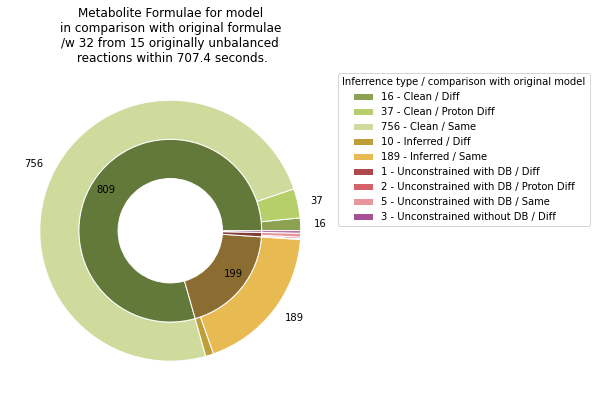

In [7]:
balancer.generate_visual_report().show()

### Metabolite Report
The algorithm should be able to give a reason for every assignment that it chooses. We can have a look at these reasons in the metabolite report of the balancer.

The report holds valuable information how the algorithm decided which assignment to choose and can be useful during further manual curation. The entries of the resulting DataFrame are the following:
* **Id**: Id of the metabolite in the model.
* **Name**: Name of the metabolite in the model.
* **Determined Formula**: Formula that was assigned by the algorithm.
* **Determined Charge**: Charge that was assigned by the algorithm.
* **Previous Formula**: Formula that was assigned before the algorithm.
* **Previous Charge**: Charge that was assigned before the algorithm.
* **Inferrence Type**: Category of how the assignment was determined.
    - Unconstrained: No information about the metabolite was found or only incomplete (wildcard containing) formulae were found and we could not find a concrete formula either. Should contain a wildcard.
    - Inferred: No information about the metabolite was found or only incomplete (wildcard containing formulae were found, however we arrived at a concrete formula. Should not contain a wildcard.
    - Clean: Information about the metabolite was found and used.
* **Reasoning**: Reasoning how the assignment was determined. Can contain:
    - database name:database identifier: The formula could be found in this database under this identifier.
    - (unconstrained) Target: This assignment was chosen because it is the same as in the original (target) model. Unconstrained means that the original (target) model seemed to be missing a wildcard symbol that was thus added.
    - Reaction_id (metabolite id -> Reasoning...): The assignment for this metabolite must follow from other reasons. The given reaction id and metabolite reasons make it so that if the model must be balanced, this metabolite must have the determined assignment.
    - Used Databases: The databases which back up the determined assignment.
    - Previous Databases: The databases which back up the previous assignment.

In [8]:
metabolite_report_df = balancer.generate_metabolite_report()
metabolite_report_df[::200]

,Id,Name,Determined Formula,Determined Charge,Previous Formula,Previous Charge,Inferrence Type,Reasoning,Used Databases,Previous Databases,Similarity
0,M_12dgr140_c,"1,2-Diacyl-sn-glycerol (ditetradecanoyl, n-C14:0)",C31H60O5,0,C31H60O5,0,Inferred,unconstrained Target & Adherence,,,Same
200,M_dhlpro_c,Dihydrolipolprotein H2S2X,C8H16NO2R,0,C8H16NO2R,0,Unconstrained,unconstrained Target & Adherence & seed.compou...,seed.compound:cpd12225,seed.compound:cpd12225,Same
400,M_hx2coa_c,Trans-Hex-2-enoyl-CoA,C27H40N7O17P3S,-4,C27H40N7O17P3S,-4,Clean,unconstrained Target & Adherence & seed.compou...,seed.compound:cpd03125,seed.compound:cpd03125,Same
600,M_5dglcn_e,5-Dehydro-D-gluconate,C6H9O7,-1,C6H9O7,-1,Clean,unconstrained Target & Adherence & metanetx.ch...,"metanetx.chemical:MNXM963, seed.compound:cpd00781","metanetx.chemical:MNXM963, seed.compound:cpd00781",Same
800,M_mqn8_c,Menaquinone 8,C51H72O2,0,C51H72O2,0,Clean,unconstrained Target & Adherence & metanetx.ch...,"metanetx.chemical:MNXM509, seed.compound:cpd15500","metanetx.chemical:MNXM509, seed.compound:cpd15500",Same
1000,M_prpp_c,5-Phospho-alpha-D-ribose 1-diphosphate,C5H9O14P3,-4,C5H8O14P3,-5,Clean,seed.compound:cpd00103,seed.compound:cpd00103,,Proton Diff


Usually we are interested in the assignments which differ from the original report. We can do this by indexing the Dataframe accordingly.

In [9]:
# If you like to see the entire report, uncomment the following line
#pandas.set_option("display.max_row", None)
metabolite_report_df[metabolite_report_df["Similarity"] != "Same"]

,Id,Name,Determined Formula,Determined Charge,Previous Formula,Previous Charge,Inferrence Type,Reasoning,Used Databases,Previous Databases,Similarity
189,M_lysglugly_e,Lysine-glutamine-glycine tripeptide,C13H26N4O7,0,C13H26N4O7,1,Inferred,,,,Diff
190,M_lysglugly_c,Lysine-glutamine-glycine tripeptide,C13H26N4O7,0,C13H26N4O7,1,Inferred,R_AMPEP16: (M_glu__L_c -> Adherence & seed.com...,,,Diff
191,M_abg4_e,4-aminobenzoate-glutamate,C12H14N2O5,0,C12H11N2O5,0,Inferred,,,,Diff
192,M_s_e,Sulfur,H2S,0,S,0,Inferred,,,,Diff
193,M_istfrnA_e,Iron bound extracellular staphyloferrin A,C17FeH22N2O14,0,C17FeH24N2O14,0,Inferred,R_SMIA2abc: (M_adp_c -> seed.compound:cpd00008...,,,Diff
...,...,...,...,...,...,...,...,...,...,...,...
1014,M_h2s_e,Hydrogen sulfide,HS,-1,H2S,0,Clean,"seed.compound:cpd00239, seed.compound:cpd24697","seed.compound:cpd00239, seed.compound:cpd24697",,Proton Diff
1015,M_mcbtt_c,Mycobactin T,C47H77N5O10,0,C43H71N5O10,2,Clean,"metanetx.chemical:MNXM62700, seed.compound:cpd...","metanetx.chemical:MNXM62700, seed.compound:cpd...",,Diff
1016,M_nh3_c,Ammonia,H4N,1,H3N,0,Clean,"seed.compound:cpd00013, seed.compound:cpd19013","seed.compound:cpd00013, seed.compound:cpd19013",,Proton Diff
1017,M_pprdn_c,Piperideine,C5H10N,1,C5H9N,0,Clean,"seed.compound:cpd03691, metanetx.chemical:MNXM...","seed.compound:cpd03691, metanetx.chemical:MNXM...",,Proton Diff


We might also be interested in all assignments which are not backed by a database:

In [10]:
metabolite_report_df[metabolite_report_df["Used Databases"] == ""]

,Id,Name,Determined Formula,Determined Charge,Previous Formula,Previous Charge,Inferrence Type,Reasoning,Used Databases,Previous Databases,Similarity
0,M_12dgr140_c,"1,2-Diacyl-sn-glycerol (ditetradecanoyl, n-C14:0)",C31H60O5,0,C31H60O5,0,Inferred,unconstrained Target & Adherence,,,Same
1,M_12dgr140_p,"1,2-Diacyl-sn-glycerol (ditetradecanoyl, n-C14:0)",C31H60O5,0,C31H60O5,0,Inferred,unconstrained Target & Adherence,,,Same
2,M_1ag160_e,1 Acyl sn glycerol hexadecanoate,C19H38O4,0,C19H38O4,0,Inferred,unconstrained Target & Adherence,,,Same
3,M_1ag180_e,1 Acyl sn glycerol octadecanoate,C21H42O4,0,C21H42O4,0,Inferred,unconstrained Target & Adherence,,,Same
4,M_1ag181d9_e,1 Acyl sn glycerol nC181d9,C21H40O4,0,C21H40O4,0,Inferred,unconstrained Target & Adherence,,,Same
...,...,...,...,...,...,...,...,...,...,...,...
197,M_mlthf_c,"5,10-Methylenetetrahydrofolate",C20H19N7O6,0,C20H21N7O6,-2,Inferred,R_GCCb: (M_dhlpro_c -> Adherence & seed.compou...,,,Diff
198,M_ficytc_c,Ferricytochrome c C42H52FeN8O6S2,C42FeH42N8O82,-1,C42FeH52N8O6S2,1,Inferred,R_CYO1_KT: (M_focytc_c -> metanetx.chemical:MN...,,,Diff
205,M_glutrna_c,L-Glutamyl-tRNA(Glu),C34H40N13O25P4R,-2,C33H36N12O24P3R,-8,Unconstrained,,,,Diff
206,M_trnaglu_c,TRNA (Glu),C29H35N12O22P4R,0,C28H34N11O21P3R,-3,Unconstrained,,,metanetx.chemical:MNXM90886,Diff


### Reaction Report
Finally, especially for further curation, we might be interested in the remaining imbalanced reactions. For this the algorithm can also provide a report.

The report also includes reactions which are technically balanced but where many protons had to be added to arrive at that result.

The fields are as follows:
* **Id**: Id of the reaction in the model.
* **Unbalanced Reaction**: Name of the reaction in the model and corresponding equation.
* **Unbalanced Type**: Type of imbalance. Can be both Mass and charge, only mass, only charge or high proton count.
* **Reason**: Set of reactions which caused the reaction to be imbalanced. This effectively means that these reactions could not be balanced together. The sets are minimal, but for example for BTS2, it would not help to remove HCYSMT, as BTS2 would require protons to have no charge and HCYSMT is only one of many reactions which then would not be balanced.
* **Shared Metabolites**: Metabolites which are shared between the reactions which are listed in Reason. Can give an indication where the problem might lie.
* **Mass Difference**: Mass imbalance.
* **Charge Difference**: Charge imbalance.

In [11]:
balancer.generate_reaction_report()

,Id,Unbalanced Reaction,Unbalanced Type,Reason,Shared Metabolites,Mass Difference,Charge Difference
0,R_CMCBTFL,"Reaction(id='R_CMCBTFL', name='CMCBTFL', metab...","Mass, Charge",R_CMCBTFL,"M_h_e, M_fe3_e, M_fcmcbtt_c, M_cmcbtt_c",Fe: -1.0,-1.0
1,R_CMCBTFU,"Reaction(id='R_CMCBTFU', name='CMCBTFU', metab...","Mass, Charge",R_CMCBTFU,"M_fe3_c, M_h_c, M_fcmcbtt_c, M_cmcbtt_c",Fe: 1.0,1.0
2,R_CREAT,"Reaction(id='R_CREAT', name='Creatinase', meta...","Mass, Charge",R_CREAT,"M_sarcs_c, M_h2o_c, M_urea_c, M_h_c, M_creat_c",O: 1.0,-2.0
3,R_CYO1_KT,"Reaction(id='R_CYO1_KT', name='Ubiquinol cyt...","Mass, Charge",R_CYO1_KT,"M_ficytc_c, M_q8h2_c, M_h_c, M_q8_c, M_focytc_...","C: -18.0, N: -8.0, O: -156.0",28.0
4,R_CYO1b,"Reaction(id='R_CYO1b', name='CYO1b', metabolit...","Mass, Charge",R_CYO1b,"M_ficytc_c, M_h2o_c, M_h_c, M_focytc_c, M_o2_c","C: 18.0, N: 8.0, O: 156.0",-28.0
5,R_FCLT2,"Reaction(id='R_FCLT2', name='FCLT2', metabolit...","Mass, Charge",R_FCLT2,"M_ppp9_c, M_fmcbtt_c, M_h_c, M_pheme_c, M_mcbtt_c",C: 4.0,-8.0
6,R_FETRANS,"Reaction(id='R_FETRANS', name='FETRANS', metab...","Mass, Charge",R_FETRANS,"M_fe2_c, M_fmcbtt_c, M_mcbtt_c, M_h_c",C: 4.0,-8.0
7,R_MCBTS3,"Reaction(id='R_MCBTS3', name='MCBTS3', metabol...",Mass,R_MCBTS3,"M_h_c, M_nadph_c, M_salc_c, M_ser__L_c, M_pi_c...",O: -1.0,0.0
8,R_MYCTR,"Reaction(id='R_MYCTR', name='MYCTR', metabolit...",Mass,R_MYCTR,"M_msh_c, M_h_c, M_nadph_c, M_nadp_c, M_mssg_c",S: -1.0,0.0
9,R_MYCTR2,"Reaction(id='R_MYCTR2', name='MYCTR2', metabol...",Mass,R_MYCTR2,"M_gthox_c, M_msh_c, M_h_c, M_mssg_c, M_gthrd_c",S: -1.0,0.0


### Writing Files
The mass charge curation writes directly to the model that was given to it. Thus, if we want to write our model, we can just pass the model to cobrapy. If you want to keep your old model, you should make sure to not overwrite it here.

In [12]:
balancer.model_interface.write_model("model_MCC.xml")

For the reports, we can add filenames to the functions to write the visual report to a .png file and the metabolite and reaction DataFrames to .csv files.

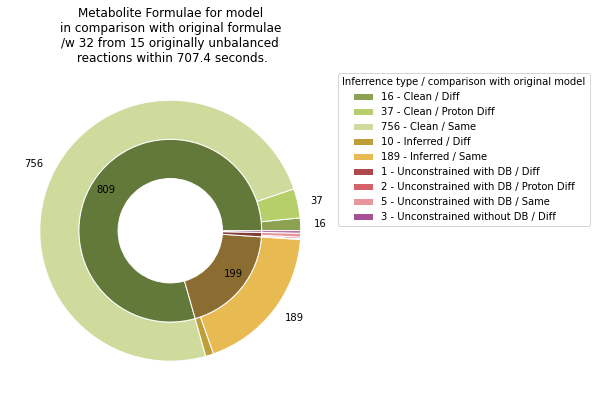

In [13]:
balancer.generate_visual_report(f"{model}_visual")
balancer.generate_metabolite_report(f"{model}_metabolites")
balancer.generate_reaction_report(f"{model}_reactions")
pass

## Fixing Assignments
For some metabolites we might want to fix their assignment, based on some knowledge that is not encoded in the used databases or is not used as it will yield a (theoretically) suboptimal result. We can do this by passing a dictionary mapping the metabolites id to the fixed assignment. If, for example, we want the metabolite with the id "M_h2o_c" to have the certain formula "CO2" and charge of 5 and the metabolite with the id "M_h_c" have a formula of "C5" and a charge of -7, we can tell this to our algorithm in the following way:

In [14]:
fixed_assignments = {"M_h2o_c" : ("CO2", 5), "M_h_c" : ("C5", -7)}
balancer = MCC.MassChargeCuration(model = model, data_path = "./data", run_optimization = True, update_ids = False, fixed_assignments = fixed_assignments)

INFO: DataCollection.py 141, gather_info: 1/1019: Getting information for M_10fthf_c
INFO: DataCollection.py 141, gather_info: 2/1019: Getting information for M_12dgr140_c
INFO: DataCollection.py 141, gather_info: 3/1019: Getting information for M_12dgr140_p
INFO: DataCollection.py 141, gather_info: 4/1019: Getting information for M_12dgr141_c
INFO: DataCollection.py 141, gather_info: 5/1019: Getting information for M_12dgr141_p
INFO: DataCollection.py 141, gather_info: 6/1019: Getting information for M_12dgr160_c
INFO: DataCollection.py 141, gather_info: 7/1019: Getting information for M_12dgr160_e
INFO: DataCollection.py 141, gather_info: 8/1019: Getting information for M_12dgr160_p
INFO: DataCollection.py 141, gather_info: 9/1019: Getting information for M_12dgr180_c
INFO: DataCollection.py 141, gather_info: 10/1019: Getting information for M_12dgr180_e
INFO: DataCollection.py 141, gather_info: 11/1019: Getting information for M_12dgr180_p
INFO: DataCollection.py 141, gather_info: 1

INFO: DataCollection.py 141, gather_info: 96/1019: Getting information for M_4adcho_c
INFO: DataCollection.py 141, gather_info: 97/1019: Getting information for M_4ahmmp_c
INFO: DataCollection.py 141, gather_info: 98/1019: Getting information for M_4ahmmp_e
INFO: DataCollection.py 141, gather_info: 99/1019: Getting information for M_4ampm_c
INFO: DataCollection.py 141, gather_info: 100/1019: Getting information for M_4c2me_c
INFO: DataCollection.py 141, gather_info: 101/1019: Getting information for M_4hadnt_c
INFO: DataCollection.py 141, gather_info: 102/1019: Getting information for M_4hba_c
INFO: DataCollection.py 141, gather_info: 103/1019: Getting information for M_4hba_e
INFO: DataCollection.py 141, gather_info: 104/1019: Getting information for M_4hglusa_c
INFO: DataCollection.py 141, gather_info: 105/1019: Getting information for M_4hpro_LT_c
INFO: DataCollection.py 141, gather_info: 106/1019: Getting information for M_4izp_c
INFO: DataCollection.py 141, gather_info: 107/1019: 

INFO: DataCollection.py 141, gather_info: 189/1019: Getting information for M_abg4_e
INFO: DataCollection.py 141, gather_info: 190/1019: Getting information for M_ac_c
INFO: DataCollection.py 141, gather_info: 191/1019: Getting information for M_ac_e
INFO: DataCollection.py 141, gather_info: 192/1019: Getting information for M_ac_p
INFO: DataCollection.py 141, gather_info: 193/1019: Getting information for M_acald_c
INFO: DataCollection.py 141, gather_info: 194/1019: Getting information for M_acald_e
INFO: DataCollection.py 141, gather_info: 195/1019: Getting information for M_acald_p
INFO: DataCollection.py 141, gather_info: 196/1019: Getting information for M_accoa_c
INFO: DataCollection.py 141, gather_info: 197/1019: Getting information for M_acetol_c
INFO: DataCollection.py 141, gather_info: 198/1019: Getting information for M_acg5p_c
INFO: DataCollection.py 141, gather_info: 199/1019: Getting information for M_acg5sa_c
INFO: DataCollection.py 141, gather_info: 200/1019: Getting in

INFO: DataCollection.py 141, gather_info: 284/1019: Getting information for M_aso3_p
INFO: DataCollection.py 141, gather_info: 285/1019: Getting information for M_aso4_c
INFO: DataCollection.py 141, gather_info: 286/1019: Getting information for M_aso4_p
INFO: DataCollection.py 141, gather_info: 287/1019: Getting information for M_asp__L_c
INFO: DataCollection.py 141, gather_info: 288/1019: Getting information for M_asp__L_e
INFO: DataCollection.py 141, gather_info: 289/1019: Getting information for M_asp__L_p
INFO: DataCollection.py 141, gather_info: 290/1019: Getting information for M_aspsa_c
INFO: DataCollection.py 141, gather_info: 291/1019: Getting information for M_atp_c
INFO: DataCollection.py 141, gather_info: 292/1019: Getting information for M_b2coa_c
INFO: DataCollection.py 141, gather_info: 293/1019: Getting information for M_betald_c
INFO: DataCollection.py 141, gather_info: 294/1019: Getting information for M_bhb_c
INFO: DataCollection.py 141, gather_info: 295/1019: Getti

INFO: DataCollection.py 141, gather_info: 380/1019: Getting information for M_ddcacoa_c
INFO: DataCollection.py 141, gather_info: 381/1019: Getting information for M_decdp_c
INFO: DataCollection.py 141, gather_info: 382/1019: Getting information for M_decdp_tb_c
INFO: DataCollection.py 141, gather_info: 383/1019: Getting information for M_dgdp_c
INFO: DataCollection.py 141, gather_info: 384/1019: Getting information for M_dgmp_c
INFO: DataCollection.py 141, gather_info: 385/1019: Getting information for M_dgsn_c
INFO: DataCollection.py 141, gather_info: 386/1019: Getting information for M_dgtp_c
INFO: DataCollection.py 141, gather_info: 387/1019: Getting information for M_dha_c
INFO: DataCollection.py 141, gather_info: 388/1019: Getting information for M_dhap_c
INFO: DataCollection.py 141, gather_info: 389/1019: Getting information for M_dhf_c
INFO: DataCollection.py 141, gather_info: 390/1019: Getting information for M_dhlam_c
INFO: DataCollection.py 141, gather_info: 391/1019: Gettin

INFO: DataCollection.py 141, gather_info: 476/1019: Getting information for M_gdp_c
INFO: DataCollection.py 141, gather_info: 477/1019: Getting information for M_gdpmann_c
INFO: DataCollection.py 141, gather_info: 478/1019: Getting information for M_gdptp_c
INFO: DataCollection.py 141, gather_info: 479/1019: Getting information for M_ggdp_c
INFO: DataCollection.py 141, gather_info: 480/1019: Getting information for M_glc__D_c
INFO: DataCollection.py 141, gather_info: 481/1019: Getting information for M_glc__D_e
INFO: DataCollection.py 141, gather_info: 482/1019: Getting information for M_glc__D_p
INFO: DataCollection.py 141, gather_info: 483/1019: Getting information for M_glcn__D_c
INFO: DataCollection.py 141, gather_info: 484/1019: Getting information for M_glcn__D_e
INFO: DataCollection.py 141, gather_info: 485/1019: Getting information for M_glcn_c
INFO: DataCollection.py 141, gather_info: 486/1019: Getting information for M_glcn_e
INFO: DataCollection.py 141, gather_info: 487/1019

INFO: DataCollection.py 141, gather_info: 571/1019: Getting information for M_gua_e
INFO: DataCollection.py 141, gather_info: 572/1019: Getting information for M_h2co3_c
INFO: DataCollection.py 141, gather_info: 573/1019: Getting information for M_h2mb4p_c
INFO: DataCollection.py 141, gather_info: 574/1019: Getting information for M_h2o2_c
INFO: DataCollection.py 141, gather_info: 575/1019: Getting information for M_h2o2_e
INFO: DataCollection.py 141, gather_info: 576/1019: Getting information for M_h2o2_p
INFO: DataCollection.py 141, gather_info: 577/1019: Getting information for M_h2o_c
INFO: DataCollection.py 141, gather_info: 578/1019: Getting information for M_h2o_e
INFO: DataCollection.py 141, gather_info: 579/1019: Getting information for M_h2o_p
INFO: DataCollection.py 141, gather_info: 580/1019: Getting information for M_h2s_c
INFO: DataCollection.py 141, gather_info: 581/1019: Getting information for M_h2s_e
INFO: DataCollection.py 141, gather_info: 582/1019: Getting informat

INFO: DataCollection.py 141, gather_info: 667/1019: Getting information for M_mal__L_e
INFO: DataCollection.py 141, gather_info: 668/1019: Getting information for M_mal__L_p
INFO: DataCollection.py 141, gather_info: 669/1019: Getting information for M_malcoa_c
INFO: DataCollection.py 141, gather_info: 670/1019: Getting information for M_malt1p_c
INFO: DataCollection.py 141, gather_info: 671/1019: Getting information for M_malt_c
INFO: DataCollection.py 141, gather_info: 672/1019: Getting information for M_malt_e
INFO: DataCollection.py 141, gather_info: 673/1019: Getting information for M_malthp_c
INFO: DataCollection.py 141, gather_info: 674/1019: Getting information for M_malthx_c
INFO: DataCollection.py 141, gather_info: 675/1019: Getting information for M_maltpt_c
INFO: DataCollection.py 141, gather_info: 676/1019: Getting information for M_malttr_c
INFO: DataCollection.py 141, gather_info: 677/1019: Getting information for M_maltttr_c
INFO: DataCollection.py 141, gather_info: 678/

INFO: DataCollection.py 141, gather_info: 763/1019: Getting information for M_ocdcea_p
INFO: DataCollection.py 141, gather_info: 764/1019: Getting information for M_octa_c
INFO: DataCollection.py 141, gather_info: 765/1019: Getting information for M_octa_e
INFO: DataCollection.py 141, gather_info: 766/1019: Getting information for M_octa_p
INFO: DataCollection.py 141, gather_info: 767/1019: Getting information for M_octdp_c
INFO: DataCollection.py 141, gather_info: 768/1019: Getting information for M_odecoa_c
INFO: DataCollection.py 141, gather_info: 769/1019: Getting information for M_orn_c
INFO: DataCollection.py 141, gather_info: 770/1019: Getting information for M_orn_e
INFO: DataCollection.py 141, gather_info: 771/1019: Getting information for M_orn_p
INFO: DataCollection.py 141, gather_info: 772/1019: Getting information for M_orot5p_c
INFO: DataCollection.py 141, gather_info: 773/1019: Getting information for M_orot_c
INFO: DataCollection.py 141, gather_info: 774/1019: Getting i

INFO: DataCollection.py 141, gather_info: 859/1019: Getting information for M_pser__L_c
INFO: DataCollection.py 141, gather_info: 860/1019: Getting information for M_pt2coa_c
INFO: DataCollection.py 141, gather_info: 861/1019: Getting information for M_pta_c
INFO: DataCollection.py 141, gather_info: 862/1019: Getting information for M_pta_e
INFO: DataCollection.py 141, gather_info: 863/1019: Getting information for M_pta_p
INFO: DataCollection.py 141, gather_info: 864/1019: Getting information for M_ptcoa_c
INFO: DataCollection.py 141, gather_info: 865/1019: Getting information for M_ptcys_c
INFO: DataCollection.py 141, gather_info: 866/1019: Getting information for M_ptrc_c
INFO: DataCollection.py 141, gather_info: 867/1019: Getting information for M_ptrc_e
INFO: DataCollection.py 141, gather_info: 868/1019: Getting information for M_ptrc_p
INFO: DataCollection.py 141, gather_info: 869/1019: Getting information for M_ptth_c
INFO: DataCollection.py 141, gather_info: 870/1019: Getting i

INFO: DataCollection.py 141, gather_info: 955/1019: Getting information for M_thym_c
INFO: DataCollection.py 141, gather_info: 956/1019: Getting information for M_thym_e
INFO: DataCollection.py 141, gather_info: 957/1019: Getting information for M_thymd_c
INFO: DataCollection.py 141, gather_info: 958/1019: Getting information for M_tnt_c
INFO: DataCollection.py 141, gather_info: 959/1019: Getting information for M_tnt_e
INFO: DataCollection.py 141, gather_info: 960/1019: Getting information for M_tnt_p
INFO: DataCollection.py 141, gather_info: 961/1019: Getting information for M_tntmdh_c
INFO: DataCollection.py 141, gather_info: 962/1019: Getting information for M_tntmmh_c
INFO: DataCollection.py 141, gather_info: 963/1019: Getting information for M_trdox_c
INFO: DataCollection.py 141, gather_info: 964/1019: Getting information for M_trdrd_c
INFO: DataCollection.py 141, gather_info: 965/1019: Getting information for M_tre6p_c
INFO: DataCollection.py 141, gather_info: 966/1019: Getting 

INFO: MCC.py 52, __init__: [43.984 s] Finished formula optimization.
ERROR: util.py 95, adjust_proton_count: Could not find appropriate hydrogen to balance reaction R_2AGPEAT120.
ERROR: util.py 95, adjust_proton_count: Could not find appropriate hydrogen to balance reaction R_2AGPEAT141.
ERROR: util.py 95, adjust_proton_count: Could not find appropriate hydrogen to balance reaction R_2AGPEAT160.
ERROR: util.py 95, adjust_proton_count: Could not find appropriate hydrogen to balance reaction R_2AGPEAT161.
ERROR: util.py 95, adjust_proton_count: Could not find appropriate hydrogen to balance reaction R_2AGPGAT140.
ERROR: util.py 95, adjust_proton_count: Could not find appropriate hydrogen to balance reaction R_2AGPGAT180.
ERROR: util.py 95, adjust_proton_count: Could not find appropriate hydrogen to balance reaction R_2MAHMP.


ERROR: util.py 95, adjust_proton_count: Could not find appropriate hydrogen to balance reaction R_4HGLSD.
ERROR: util.py 95, adjust_proton_count: Could not find appropriate hydrogen to balance reaction R_5DKGR.
ERROR: util.py 95, adjust_proton_count: Could not find appropriate hydrogen to balance reaction R_5DOAN.
ERROR: util.py 95, adjust_proton_count: Could not find appropriate hydrogen to balance reaction R_AACTOOR.
ERROR: util.py 95, adjust_proton_count: Could not find appropriate hydrogen to balance reaction R_ACCOAC.
ERROR: util.py 95, adjust_proton_count: Could not find appropriate hydrogen to balance reaction R_ACGAMPM.
ERROR: util.py 95, adjust_proton_count: Could not find appropriate hydrogen to balance reaction R_ACGK.
ERROR: util.py 95, adjust_proton_count: Could not find appropriate hydrogen to balance reaction R_ACHBS.
ERROR: util.py 95, adjust_proton_count: Could not find appropriate hydrogen to balance reaction R_ACLDC.
ERROR: util.py 95, adjust_proton_count: Could not 

ERROR: util.py 95, adjust_proton_count: Could not find appropriate hydrogen to balance reaction R_ACSPHAC140.
ERROR: util.py 95, adjust_proton_count: Could not find appropriate hydrogen to balance reaction R_ACSPHAC141.
ERROR: util.py 95, adjust_proton_count: Could not find appropriate hydrogen to balance reaction R_ACSPHAC141d5.
ERROR: util.py 95, adjust_proton_count: Could not find appropriate hydrogen to balance reaction R_ACSPHAC142.
ERROR: util.py 95, adjust_proton_count: Could not find appropriate hydrogen to balance reaction R_ACSPHAC160.
ERROR: util.py 95, adjust_proton_count: Could not find appropriate hydrogen to balance reaction R_ACSPHAC40.
ERROR: util.py 95, adjust_proton_count: Could not find appropriate hydrogen to balance reaction R_ACSPHAC50.
ERROR: util.py 95, adjust_proton_count: Could not find appropriate hydrogen to balance reaction R_ACSPHAC60.
ERROR: util.py 95, adjust_proton_count: Could not find appropriate hydrogen to balance reaction R_ACSPHAC70.
ERROR: util.

ERROR: util.py 95, adjust_proton_count: Could not find appropriate hydrogen to balance reaction R_ADNUC.
ERROR: util.py 95, adjust_proton_count: Could not find appropriate hydrogen to balance reaction R_ADPRDP.
ERROR: util.py 95, adjust_proton_count: Could not find appropriate hydrogen to balance reaction R_ADPT.
ERROR: util.py 95, adjust_proton_count: Could not find appropriate hydrogen to balance reaction R_ADSK.
ERROR: util.py 95, adjust_proton_count: Could not find appropriate hydrogen to balance reaction R_ADSL1r.
ERROR: util.py 95, adjust_proton_count: Could not find appropriate hydrogen to balance reaction R_ADSL2r.
ERROR: util.py 95, adjust_proton_count: Could not find appropriate hydrogen to balance reaction R_ADSS.
ERROR: util.py 95, adjust_proton_count: Could not find appropriate hydrogen to balance reaction R_AGPR.
ERROR: util.py 95, adjust_proton_count: Could not find appropriate hydrogen to balance reaction R_AHCYSNS.
ERROR: util.py 95, adjust_proton_count: Could not find

ERROR: util.py 95, adjust_proton_count: Could not find appropriate hydrogen to balance reaction R_ALAR.
ERROR: util.py 95, adjust_proton_count: Could not find appropriate hydrogen to balance reaction R_ALATA_L.
ERROR: util.py 95, adjust_proton_count: Could not find appropriate hydrogen to balance reaction R_ALCD19y.
ERROR: util.py 95, adjust_proton_count: Could not find appropriate hydrogen to balance reaction R_ALCD2ir.
ERROR: util.py 95, adjust_proton_count: Could not find appropriate hydrogen to balance reaction R_ALCD2y.
ERROR: util.py 95, adjust_proton_count: Could not find appropriate hydrogen to balance reaction R_ALDD1.
ERROR: util.py 95, adjust_proton_count: Could not find appropriate hydrogen to balance reaction R_ALDD31.
ERROR: util.py 95, adjust_proton_count: Could not find appropriate hydrogen to balance reaction R_ALKP.
ERROR: util.py 95, adjust_proton_count: Could not find appropriate hydrogen to balance reaction R_ALPHNH.
ERROR: util.py 95, adjust_proton_count: Could no

ERROR: util.py 95, adjust_proton_count: Could not find appropriate hydrogen to balance reaction R_AMPEP16.
ERROR: util.py 95, adjust_proton_count: Could not find appropriate hydrogen to balance reaction R_AMPEP17.
ERROR: util.py 95, adjust_proton_count: Could not find appropriate hydrogen to balance reaction R_AMPEP18.
ERROR: util.py 95, adjust_proton_count: Could not find appropriate hydrogen to balance reaction R_AMPEP2.
ERROR: util.py 95, adjust_proton_count: Could not find appropriate hydrogen to balance reaction R_AMPEP3.
ERROR: util.py 95, adjust_proton_count: Could not find appropriate hydrogen to balance reaction R_AMPEP4.
ERROR: util.py 95, adjust_proton_count: Could not find appropriate hydrogen to balance reaction R_AMPEP5.
ERROR: util.py 95, adjust_proton_count: Could not find appropriate hydrogen to balance reaction R_AMPEP6.
ERROR: util.py 95, adjust_proton_count: Could not find appropriate hydrogen to balance reaction R_AMPEP7.
ERROR: util.py 95, adjust_proton_count: Cou

ERROR: util.py 95, adjust_proton_count: Could not find appropriate hydrogen to balance reaction R_ASAD.
ERROR: util.py 95, adjust_proton_count: Could not find appropriate hydrogen to balance reaction R_ASNN.
ERROR: util.py 95, adjust_proton_count: Could not find appropriate hydrogen to balance reaction R_ASNS1.
ERROR: util.py 95, adjust_proton_count: Could not find appropriate hydrogen to balance reaction R_ASPCT.
ERROR: util.py 95, adjust_proton_count: Could not find appropriate hydrogen to balance reaction R_ASPK.
ERROR: util.py 95, adjust_proton_count: Could not find appropriate hydrogen to balance reaction R_ASPT.
ERROR: util.py 95, adjust_proton_count: Could not find appropriate hydrogen to balance reaction R_ASPTA.
ERROR: util.py 95, adjust_proton_count: Could not find appropriate hydrogen to balance reaction R_ATPHs.
ERROR: util.py 95, adjust_proton_count: Could not find appropriate hydrogen to balance reaction R_ATPPRT.
ERROR: util.py 95, adjust_proton_count: Could not find app

ERROR: util.py 95, adjust_proton_count: Could not find appropriate hydrogen to balance reaction R_BPNT2.
ERROR: util.py 95, adjust_proton_count: Could not find appropriate hydrogen to balance reaction R_BTS2.
ERROR: util.py 95, adjust_proton_count: Could not find appropriate hydrogen to balance reaction R_BTS3r.
ERROR: util.py 95, adjust_proton_count: Could not find appropriate hydrogen to balance reaction R_BUTCT.
ERROR: util.py 95, adjust_proton_count: Could not find appropriate hydrogen to balance reaction R_CAT.
ERROR: util.py 95, adjust_proton_count: Could not find appropriate hydrogen to balance reaction R_CBPS.
ERROR: util.py 95, adjust_proton_count: Could not find appropriate hydrogen to balance reaction R_CDAPPA160190.
ERROR: util.py 95, adjust_proton_count: Could not find appropriate hydrogen to balance reaction R_CDAPPA190.
ERROR: util.py 95, adjust_proton_count: Could not find appropriate hydrogen to balance reaction R_CDPMEK.
ERROR: util.py 95, adjust_proton_count: Could n

ERROR: util.py 95, adjust_proton_count: Could not find appropriate hydrogen to balance reaction R_CMCBTFU.
ERROR: util.py 95, adjust_proton_count: Could not find appropriate hydrogen to balance reaction R_CPPPGO.
ERROR: util.py 95, adjust_proton_count: Could not find appropriate hydrogen to balance reaction R_CPPPGO2.
ERROR: util.py 95, adjust_proton_count: Could not find appropriate hydrogen to balance reaction R_CREAT.
ERROR: util.py 95, adjust_proton_count: Could not find appropriate hydrogen to balance reaction R_CS.
ERROR: util.py 95, adjust_proton_count: Could not find appropriate hydrogen to balance reaction R_CSND.
ERROR: util.py 95, adjust_proton_count: Could not find appropriate hydrogen to balance reaction R_CYO1b.
ERROR: util.py 95, adjust_proton_count: Could not find appropriate hydrogen to balance reaction R_CYSS.


ERROR: util.py 95, adjust_proton_count: Could not find appropriate hydrogen to balance reaction R_CYSTL.
ERROR: util.py 95, adjust_proton_count: Could not find appropriate hydrogen to balance reaction R_CYTDH.
ERROR: util.py 95, adjust_proton_count: Could not find appropriate hydrogen to balance reaction R_CYTK1.
ERROR: util.py 95, adjust_proton_count: Could not find appropriate hydrogen to balance reaction R_CYTK2.
ERROR: util.py 95, adjust_proton_count: Could not find appropriate hydrogen to balance reaction R_CYTOM.
ERROR: util.py 95, adjust_proton_count: Could not find appropriate hydrogen to balance reaction R_DACL.
ERROR: util.py 95, adjust_proton_count: Could not find appropriate hydrogen to balance reaction R_DADK.
ERROR: util.py 95, adjust_proton_count: Could not find appropriate hydrogen to balance reaction R_DAGK140.
ERROR: util.py 95, adjust_proton_count: Could not find appropriate hydrogen to balance reaction R_DAGK141.
ERROR: util.py 95, adjust_proton_count: Could not fin

ERROR: util.py 95, adjust_proton_count: Could not find appropriate hydrogen to balance reaction R_DASYN160.
ERROR: util.py 95, adjust_proton_count: Could not find appropriate hydrogen to balance reaction R_DASYN160190.
ERROR: util.py 95, adjust_proton_count: Could not find appropriate hydrogen to balance reaction R_DASYN181.
ERROR: util.py 95, adjust_proton_count: Could not find appropriate hydrogen to balance reaction R_DASYN190190.
ERROR: util.py 95, adjust_proton_count: Could not find appropriate hydrogen to balance reaction R_DB4PS.
ERROR: util.py 95, adjust_proton_count: Could not find appropriate hydrogen to balance reaction R_DCPDPS.
ERROR: util.py 95, adjust_proton_count: Could not find appropriate hydrogen to balance reaction R_DCTPD.
ERROR: util.py 95, adjust_proton_count: Could not find appropriate hydrogen to balance reaction R_DCTPD2.
ERROR: util.py 95, adjust_proton_count: Could not find appropriate hydrogen to balance reaction R_DDPA.
ERROR: util.py 95, adjust_proton_cou

ERROR: util.py 95, adjust_proton_count: Could not find appropriate hydrogen to balance reaction R_DMALRED.
ERROR: util.py 95, adjust_proton_count: Could not find appropriate hydrogen to balance reaction R_DMATT.
ERROR: util.py 95, adjust_proton_count: Could not find appropriate hydrogen to balance reaction R_DMPPS.
ERROR: util.py 95, adjust_proton_count: Could not find appropriate hydrogen to balance reaction R_DNADDP.
ERROR: util.py 95, adjust_proton_count: Could not find appropriate hydrogen to balance reaction R_DNMPPA.
ERROR: util.py 95, adjust_proton_count: Could not find appropriate hydrogen to balance reaction R_DNTPPA.
ERROR: util.py 95, adjust_proton_count: Could not find appropriate hydrogen to balance reaction R_DPCOAK.
ERROR: util.py 95, adjust_proton_count: Could not find appropriate hydrogen to balance reaction R_DPPS.
ERROR: util.py 95, adjust_proton_count: Could not find appropriate hydrogen to balance reaction R_DPR.
ERROR: util.py 95, adjust_proton_count: Could not fi

ERROR: util.py 95, adjust_proton_count: Could not find appropriate hydrogen to balance reaction R_FACOAE160.
ERROR: util.py 95, adjust_proton_count: Could not find appropriate hydrogen to balance reaction R_FACOAE161.
ERROR: util.py 95, adjust_proton_count: Could not find appropriate hydrogen to balance reaction R_FACOAE180.
ERROR: util.py 95, adjust_proton_count: Could not find appropriate hydrogen to balance reaction R_FACOAE1829Z12Z.
ERROR: util.py 95, adjust_proton_count: Could not find appropriate hydrogen to balance reaction R_FACOAE50.
ERROR: util.py 95, adjust_proton_count: Could not find appropriate hydrogen to balance reaction R_FACOAE60.
ERROR: util.py 95, adjust_proton_count: Could not find appropriate hydrogen to balance reaction R_FACOAE70.
ERROR: util.py 95, adjust_proton_count: Could not find appropriate hydrogen to balance reaction R_FACOAE80.
ERROR: util.py 95, adjust_proton_count: Could not find appropriate hydrogen to balance reaction R_FACOAE90.
ERROR: util.py 95, 

ERROR: util.py 95, adjust_proton_count: Could not find appropriate hydrogen to balance reaction R_FAD_14.
ERROR: util.py 95, adjust_proton_count: Could not find appropriate hydrogen to balance reaction R_FAO1.
ERROR: util.py 95, adjust_proton_count: Could not find appropriate hydrogen to balance reaction R_FAO11.
ERROR: util.py 95, adjust_proton_count: Could not find appropriate hydrogen to balance reaction R_FAO2.
ERROR: util.py 95, adjust_proton_count: Could not find appropriate hydrogen to balance reaction R_FAO3.
ERROR: util.py 95, adjust_proton_count: Could not find appropriate hydrogen to balance reaction R_FAS120.
ERROR: util.py 95, adjust_proton_count: Could not find appropriate hydrogen to balance reaction R_FAS140.
ERROR: util.py 95, adjust_proton_count: Could not find appropriate hydrogen to balance reaction R_FBA.
ERROR: util.py 95, adjust_proton_count: Could not find appropriate hydrogen to balance reaction R_FBP.
ERROR: util.py 95, adjust_proton_count: Could not find appr

ERROR: util.py 95, adjust_proton_count: Could not find appropriate hydrogen to balance reaction R_FETRANS.
ERROR: util.py 95, adjust_proton_count: Could not find appropriate hydrogen to balance reaction R_FFSD.
ERROR: util.py 95, adjust_proton_count: Could not find appropriate hydrogen to balance reaction R_FGFT.
ERROR: util.py 95, adjust_proton_count: Could not find appropriate hydrogen to balance reaction R_FGLU.
ERROR: util.py 95, adjust_proton_count: Could not find appropriate hydrogen to balance reaction R_FMNAT.
ERROR: util.py 95, adjust_proton_count: Could not find appropriate hydrogen to balance reaction R_FMNRx.
ERROR: util.py 95, adjust_proton_count: Could not find appropriate hydrogen to balance reaction R_FMNRx2.
ERROR: util.py 95, adjust_proton_count: Could not find appropriate hydrogen to balance reaction R_FOLD3.
ERROR: util.py 95, adjust_proton_count: Could not find appropriate hydrogen to balance reaction R_FOMETRi.
ERROR: util.py 95, adjust_proton_count: Could not fin

ERROR: util.py 95, adjust_proton_count: Could not find appropriate hydrogen to balance reaction R_G3PD1ir.
ERROR: util.py 95, adjust_proton_count: Could not find appropriate hydrogen to balance reaction R_G3PD5.
ERROR: util.py 95, adjust_proton_count: Could not find appropriate hydrogen to balance reaction R_G3PT.
ERROR: util.py 95, adjust_proton_count: Could not find appropriate hydrogen to balance reaction R_G5SADs.
ERROR: util.py 95, adjust_proton_count: Could not find appropriate hydrogen to balance reaction R_G5SD.
ERROR: util.py 95, adjust_proton_count: Could not find appropriate hydrogen to balance reaction R_G5SD2.
ERROR: util.py 95, adjust_proton_count: Could not find appropriate hydrogen to balance reaction R_G6PDH2r.
ERROR: util.py 95, adjust_proton_count: Could not find appropriate hydrogen to balance reaction R_G6PP.
ERROR: util.py 95, adjust_proton_count: Could not find appropriate hydrogen to balance reaction R_GALKr.
ERROR: util.py 95, adjust_proton_count: Could not fin

ERROR: util.py 95, adjust_proton_count: Could not find appropriate hydrogen to balance reaction R_GLGC.
ERROR: util.py 95, adjust_proton_count: Could not find appropriate hydrogen to balance reaction R_GLNS.
ERROR: util.py 95, adjust_proton_count: Could not find appropriate hydrogen to balance reaction R_GLU5K.
ERROR: util.py 95, adjust_proton_count: Could not find appropriate hydrogen to balance reaction R_GLUDy.
ERROR: util.py 95, adjust_proton_count: Could not find appropriate hydrogen to balance reaction R_GLUN.
ERROR: util.py 95, adjust_proton_count: Could not find appropriate hydrogen to balance reaction R_GLUPRT.
ERROR: util.py 95, adjust_proton_count: Could not find appropriate hydrogen to balance reaction R_GLUR.
ERROR: util.py 95, adjust_proton_count: Could not find appropriate hydrogen to balance reaction R_GLUTARH.
ERROR: util.py 95, adjust_proton_count: Could not find appropriate hydrogen to balance reaction R_GLUTRR.
ERROR: util.py 95, adjust_proton_count: Could not find 

ERROR: util.py 95, adjust_proton_count: Could not find appropriate hydrogen to balance reaction R_GLYCK2.
ERROR: util.py 95, adjust_proton_count: Could not find appropriate hydrogen to balance reaction R_GLYCL.
ERROR: util.py 95, adjust_proton_count: Could not find appropriate hydrogen to balance reaction R_GLYCLTDx.
ERROR: util.py 95, adjust_proton_count: Could not find appropriate hydrogen to balance reaction R_GLYCLTDy.
ERROR: util.py 95, adjust_proton_count: Could not find appropriate hydrogen to balance reaction R_GLYCL_2.
ERROR: util.py 95, adjust_proton_count: Could not find appropriate hydrogen to balance reaction R_GLYCS_I.
ERROR: util.py 95, adjust_proton_count: Could not find appropriate hydrogen to balance reaction R_GLYCS_II.
ERROR: util.py 95, adjust_proton_count: Could not find appropriate hydrogen to balance reaction R_GLYCTO3.
ERROR: util.py 95, adjust_proton_count: Could not find appropriate hydrogen to balance reaction R_GLYCTO4.
ERROR: util.py 95, adjust_proton_coun

ERROR: util.py 95, adjust_proton_count: Could not find appropriate hydrogen to balance reaction R_GLYOX.
ERROR: util.py 95, adjust_proton_count: Could not find appropriate hydrogen to balance reaction R_GLYOX3.
ERROR: util.py 95, adjust_proton_count: Could not find appropriate hydrogen to balance reaction R_GLYOX_1.
ERROR: util.py 95, adjust_proton_count: Could not find appropriate hydrogen to balance reaction R_GLYPHEAP.
ERROR: util.py 95, adjust_proton_count: Could not find appropriate hydrogen to balance reaction R_GLYPHEHYc.
ERROR: util.py 95, adjust_proton_count: Could not find appropriate hydrogen to balance reaction R_GLYTYRAP.
ERROR: util.py 95, adjust_proton_count: Could not find appropriate hydrogen to balance reaction R_GMPS2.
ERROR: util.py 95, adjust_proton_count: Could not find appropriate hydrogen to balance reaction R_GND.
ERROR: util.py 95, adjust_proton_count: Could not find appropriate hydrogen to balance reaction R_GNK.
ERROR: util.py 95, adjust_proton_count: Could 

ERROR: util.py 95, adjust_proton_count: Could not find appropriate hydrogen to balance reaction R_H2CO3D.
ERROR: util.py 95, adjust_proton_count: Could not find appropriate hydrogen to balance reaction R_H2CO3D2.
ERROR: util.py 95, adjust_proton_count: Could not find appropriate hydrogen to balance reaction R_H2SO.
ERROR: util.py 95, adjust_proton_count: Could not find appropriate hydrogen to balance reaction R_HACD1i.
ERROR: util.py 95, adjust_proton_count: Could not find appropriate hydrogen to balance reaction R_HBCHLR.
ERROR: util.py 95, adjust_proton_count: Could not find appropriate hydrogen to balance reaction R_HBRCH.
ERROR: util.py 95, adjust_proton_count: Could not find appropriate hydrogen to balance reaction R_HCO3E.
ERROR: util.py 95, adjust_proton_count: Could not find appropriate hydrogen to balance reaction R_HCYSMT.
ERROR: util.py 95, adjust_proton_count: Could not find appropriate hydrogen to balance reaction R_HEMEOS.
ERROR: util.py 95, adjust_proton_count: Could not

ERROR: util.py 95, adjust_proton_count: Could not find appropriate hydrogen to balance reaction R_HMR_0188.
ERROR: util.py 95, adjust_proton_count: Could not find appropriate hydrogen to balance reaction R_HMR_0260.
ERROR: util.py 95, adjust_proton_count: Could not find appropriate hydrogen to balance reaction R_HPCOR.
ERROR: util.py 95, adjust_proton_count: Could not find appropriate hydrogen to balance reaction R_HPHL.
ERROR: util.py 95, adjust_proton_count: Could not find appropriate hydrogen to balance reaction R_HPPK.
ERROR: util.py 95, adjust_proton_count: Could not find appropriate hydrogen to balance reaction R_HPPK2.
ERROR: util.py 95, adjust_proton_count: Could not find appropriate hydrogen to balance reaction R_HPROx.
ERROR: util.py 95, adjust_proton_count: Could not find appropriate hydrogen to balance reaction R_HPYRP.
ERROR: util.py 95, adjust_proton_count: Could not find appropriate hydrogen to balance reaction R_HPYRRx.
ERROR: util.py 95, adjust_proton_count: Could not 

ERROR: util.py 95, adjust_proton_count: Could not find appropriate hydrogen to balance reaction R_IPMD.
ERROR: util.py 95, adjust_proton_count: Could not find appropriate hydrogen to balance reaction R_IPPMIa.
ERROR: util.py 95, adjust_proton_count: Could not find appropriate hydrogen to balance reaction R_IPPMIb.
ERROR: util.py 95, adjust_proton_count: Could not find appropriate hydrogen to balance reaction R_IPPS.
ERROR: util.py 95, adjust_proton_count: Could not find appropriate hydrogen to balance reaction R_IVCS.
ERROR: util.py 95, adjust_proton_count: Could not find appropriate hydrogen to balance reaction R_IZPN.
ERROR: util.py 95, adjust_proton_count: Could not find appropriate hydrogen to balance reaction R_IZPN_1.
ERROR: util.py 95, adjust_proton_count: Could not find appropriate hydrogen to balance reaction R_KARA1.
ERROR: util.py 95, adjust_proton_count: Could not find appropriate hydrogen to balance reaction R_KARA2.
ERROR: util.py 95, adjust_proton_count: Could not find a

ERROR: util.py 95, adjust_proton_count: Could not find appropriate hydrogen to balance reaction R_LEUTA.
ERROR: util.py 95, adjust_proton_count: Could not find appropriate hydrogen to balance reaction R_LTHRK.
ERROR: util.py 95, adjust_proton_count: Could not find appropriate hydrogen to balance reaction R_LYSDC.
ERROR: util.py 95, adjust_proton_count: Could not find appropriate hydrogen to balance reaction R_L_LACD2.
ERROR: util.py 95, adjust_proton_count: Could not find appropriate hydrogen to balance reaction R_L_LACD3.
ERROR: util.py 95, adjust_proton_count: Could not find appropriate hydrogen to balance reaction R_L_LACD3_1.
ERROR: util.py 95, adjust_proton_count: Could not find appropriate hydrogen to balance reaction R_M1PD.
ERROR: util.py 95, adjust_proton_count: Could not find appropriate hydrogen to balance reaction R_MAK.
ERROR: util.py 95, adjust_proton_count: Could not find appropriate hydrogen to balance reaction R_MALTT.
ERROR: util.py 95, adjust_proton_count: Could not 

ERROR: util.py 95, adjust_proton_count: Could not find appropriate hydrogen to balance reaction R_MCBTS3.
ERROR: util.py 95, adjust_proton_count: Could not find appropriate hydrogen to balance reaction R_MCD.
ERROR: util.py 95, adjust_proton_count: Could not find appropriate hydrogen to balance reaction R_MCITD.
ERROR: util.py 95, adjust_proton_count: Could not find appropriate hydrogen to balance reaction R_MCSNAH.
ERROR: util.py 95, adjust_proton_count: Could not find appropriate hydrogen to balance reaction R_MDH.
ERROR: util.py 95, adjust_proton_count: Could not find appropriate hydrogen to balance reaction R_MDH2.
ERROR: util.py 95, adjust_proton_count: Could not find appropriate hydrogen to balance reaction R_MDH3.
ERROR: util.py 95, adjust_proton_count: Could not find appropriate hydrogen to balance reaction R_MDH3_1.
ERROR: util.py 95, adjust_proton_count: Could not find appropriate hydrogen to balance reaction R_MECDPDH.
ERROR: util.py 95, adjust_proton_count: Could not find a

ERROR: util.py 95, adjust_proton_count: Could not find appropriate hydrogen to balance reaction R_MLTG5.
ERROR: util.py 95, adjust_proton_count: Could not find appropriate hydrogen to balance reaction R_MMCD.
ERROR: util.py 95, adjust_proton_count: Could not find appropriate hydrogen to balance reaction R_MN6PP.
ERROR: util.py 95, adjust_proton_count: Could not find appropriate hydrogen to balance reaction R_MOHMT.
ERROR: util.py 95, adjust_proton_count: Could not find appropriate hydrogen to balance reaction R_MOTH3.
ERROR: util.py 95, adjust_proton_count: Could not find appropriate hydrogen to balance reaction R_MOTS3.
ERROR: util.py 95, adjust_proton_count: Could not find appropriate hydrogen to balance reaction R_MSHAMID.
ERROR: util.py 95, adjust_proton_count: Could not find appropriate hydrogen to balance reaction R_MSHS.
ERROR: util.py 95, adjust_proton_count: Could not find appropriate hydrogen to balance reaction R_MS_1.
ERROR: util.py 95, adjust_proton_count: Could not find a

ERROR: util.py 95, adjust_proton_count: Could not find appropriate hydrogen to balance reaction R_NADN.
ERROR: util.py 95, adjust_proton_count: Could not find appropriate hydrogen to balance reaction R_NADPHHR.
ERROR: util.py 95, adjust_proton_count: Could not find appropriate hydrogen to balance reaction R_NADPHQR2.
ERROR: util.py 95, adjust_proton_count: Could not find appropriate hydrogen to balance reaction R_NADPHXD.
ERROR: util.py 95, adjust_proton_count: Could not find appropriate hydrogen to balance reaction R_NADPHXE.
ERROR: util.py 95, adjust_proton_count: Could not find appropriate hydrogen to balance reaction R_NADS1.
ERROR: util.py 95, adjust_proton_count: Could not find appropriate hydrogen to balance reaction R_NAPRT.
ERROR: util.py 95, adjust_proton_count: Could not find appropriate hydrogen to balance reaction R_NDP3.
ERROR: util.py 95, adjust_proton_count: Could not find appropriate hydrogen to balance reaction R_NDPK1.
ERROR: util.py 95, adjust_proton_count: Could no

ERROR: util.py 95, adjust_proton_count: Could not find appropriate hydrogen to balance reaction R_NNATr.
ERROR: util.py 95, adjust_proton_count: Could not find appropriate hydrogen to balance reaction R_NP1.
ERROR: util.py 95, adjust_proton_count: Could not find appropriate hydrogen to balance reaction R_NP1_1.
ERROR: util.py 95, adjust_proton_count: Could not find appropriate hydrogen to balance reaction R_NPHS.
ERROR: util.py 95, adjust_proton_count: Could not find appropriate hydrogen to balance reaction R_NTD1.
ERROR: util.py 95, adjust_proton_count: Could not find appropriate hydrogen to balance reaction R_NTD2.
ERROR: util.py 95, adjust_proton_count: Could not find appropriate hydrogen to balance reaction R_NTD4.
ERROR: util.py 95, adjust_proton_count: Could not find appropriate hydrogen to balance reaction R_NTD5.
ERROR: util.py 95, adjust_proton_count: Could not find appropriate hydrogen to balance reaction R_NTD7.
ERROR: util.py 95, adjust_proton_count: Could not find appropri

ERROR: util.py 95, adjust_proton_count: Could not find appropriate hydrogen to balance reaction R_OCBT.
ERROR: util.py 95, adjust_proton_count: Could not find appropriate hydrogen to balance reaction R_OCDOR.
ERROR: util.py 95, adjust_proton_count: Could not find appropriate hydrogen to balance reaction R_OCOAT2r.
ERROR: util.py 95, adjust_proton_count: Could not find appropriate hydrogen to balance reaction R_OCTDPS.
ERROR: util.py 95, adjust_proton_count: Could not find appropriate hydrogen to balance reaction R_OIVD1r.
ERROR: util.py 95, adjust_proton_count: Could not find appropriate hydrogen to balance reaction R_OMCDC.
ERROR: util.py 95, adjust_proton_count: Could not find appropriate hydrogen to balance reaction R_OMPDC.
ERROR: util.py 95, adjust_proton_count: Could not find appropriate hydrogen to balance reaction R_ORNCD.
ERROR: util.py 95, adjust_proton_count: Could not find appropriate hydrogen to balance reaction R_ORNTA.
ERROR: util.py 95, adjust_proton_count: Could not fi

ERROR: util.py 95, adjust_proton_count: Could not find appropriate hydrogen to balance reaction R_PDHcr.
ERROR: util.py 95, adjust_proton_count: Could not find appropriate hydrogen to balance reaction R_PDXPP.
ERROR: util.py 95, adjust_proton_count: Could not find appropriate hydrogen to balance reaction R_PEPCK_re.
ERROR: util.py 95, adjust_proton_count: Could not find appropriate hydrogen to balance reaction R_PFK.
ERROR: util.py 95, adjust_proton_count: Could not find appropriate hydrogen to balance reaction R_PFL.
ERROR: util.py 95, adjust_proton_count: Could not find appropriate hydrogen to balance reaction R_PGAMT.
ERROR: util.py 95, adjust_proton_count: Could not find appropriate hydrogen to balance reaction R_PGCD.
ERROR: util.py 95, adjust_proton_count: Could not find appropriate hydrogen to balance reaction R_PGI.
ERROR: util.py 95, adjust_proton_count: Could not find appropriate hydrogen to balance reaction R_PGK.
ERROR: util.py 95, adjust_proton_count: Could not find approp

ERROR: util.py 95, adjust_proton_count: Could not find appropriate hydrogen to balance reaction R_PLPS.
ERROR: util.py 95, adjust_proton_count: Could not find appropriate hydrogen to balance reaction R_PMANM.
ERROR: util.py 95, adjust_proton_count: Could not find appropriate hydrogen to balance reaction R_PMDPHT.
ERROR: util.py 95, adjust_proton_count: Could not find appropriate hydrogen to balance reaction R_PMPK.
ERROR: util.py 95, adjust_proton_count: Could not find appropriate hydrogen to balance reaction R_PNCDC.
ERROR: util.py 95, adjust_proton_count: Could not find appropriate hydrogen to balance reaction R_PNCDC_1.
ERROR: util.py 95, adjust_proton_count: Could not find appropriate hydrogen to balance reaction R_PNP_1.
ERROR: util.py 95, adjust_proton_count: Could not find appropriate hydrogen to balance reaction R_PNTK.
ERROR: util.py 95, adjust_proton_count: Could not find appropriate hydrogen to balance reaction R_POX.
ERROR: util.py 95, adjust_proton_count: Could not find ap

ERROR: util.py 95, adjust_proton_count: Could not find appropriate hydrogen to balance reaction R_PPND.
ERROR: util.py 95, adjust_proton_count: Could not find appropriate hydrogen to balance reaction R_PPNDH.
ERROR: util.py 95, adjust_proton_count: Could not find appropriate hydrogen to balance reaction R_PPPGO.
ERROR: util.py 95, adjust_proton_count: Could not find appropriate hydrogen to balance reaction R_PPRDNDH.
ERROR: util.py 95, adjust_proton_count: Could not find appropriate hydrogen to balance reaction R_PRAGSr.
ERROR: util.py 95, adjust_proton_count: Could not find appropriate hydrogen to balance reaction R_PRAIi.
ERROR: util.py 95, adjust_proton_count: Could not find appropriate hydrogen to balance reaction R_PRAMPC.
ERROR: util.py 95, adjust_proton_count: Could not find appropriate hydrogen to balance reaction R_PRASCSi.
ERROR: util.py 95, adjust_proton_count: Could not find appropriate hydrogen to balance reaction R_PRATPP.
ERROR: util.py 95, adjust_proton_count: Could not

ERROR: util.py 95, adjust_proton_count: Could not find appropriate hydrogen to balance reaction R_PUNP1_1.
ERROR: util.py 95, adjust_proton_count: Could not find appropriate hydrogen to balance reaction R_PUNP2_1.
ERROR: util.py 95, adjust_proton_count: Could not find appropriate hydrogen to balance reaction R_PUNP3_1.
ERROR: util.py 95, adjust_proton_count: Could not find appropriate hydrogen to balance reaction R_PUNP4_1.
ERROR: util.py 95, adjust_proton_count: Could not find appropriate hydrogen to balance reaction R_PUNP5_1.
ERROR: util.py 95, adjust_proton_count: Could not find appropriate hydrogen to balance reaction R_PUNP6_1.
ERROR: util.py 95, adjust_proton_count: Could not find appropriate hydrogen to balance reaction R_PUNP7_1.
ERROR: util.py 95, adjust_proton_count: Could not find appropriate hydrogen to balance reaction R_PUTA3.
ERROR: util.py 95, adjust_proton_count: Could not find appropriate hydrogen to balance reaction R_PYDAMK.
ERROR: util.py 95, adjust_proton_count: 

ERROR: util.py 95, adjust_proton_count: Could not find appropriate hydrogen to balance reaction R_RHACOAET60.
ERROR: util.py 95, adjust_proton_count: Could not find appropriate hydrogen to balance reaction R_RHCCE.
ERROR: util.py 95, adjust_proton_count: Could not find appropriate hydrogen to balance reaction R_RNDR1.
ERROR: util.py 95, adjust_proton_count: Could not find appropriate hydrogen to balance reaction R_RNDR1b.
ERROR: util.py 95, adjust_proton_count: Could not find appropriate hydrogen to balance reaction R_RNDR2.
ERROR: util.py 95, adjust_proton_count: Could not find appropriate hydrogen to balance reaction R_RNDR2b.
ERROR: util.py 95, adjust_proton_count: Could not find appropriate hydrogen to balance reaction R_RNDR3.
ERROR: util.py 95, adjust_proton_count: Could not find appropriate hydrogen to balance reaction R_RNDR3b.
ERROR: util.py 95, adjust_proton_count: Could not find appropriate hydrogen to balance reaction R_RNDR4.
ERROR: util.py 95, adjust_proton_count: Could n

ERROR: util.py 95, adjust_proton_count: Could not find appropriate hydrogen to balance reaction R_SHK3Dr.
ERROR: util.py 95, adjust_proton_count: Could not find appropriate hydrogen to balance reaction R_SHKK.
ERROR: util.py 95, adjust_proton_count: Could not find appropriate hydrogen to balance reaction R_SHSL1.
ERROR: util.py 95, adjust_proton_count: Could not find appropriate hydrogen to balance reaction R_SHSL2.
ERROR: util.py 95, adjust_proton_count: Could not find appropriate hydrogen to balance reaction R_SHSL4r.
ERROR: util.py 95, adjust_proton_count: Could not find appropriate hydrogen to balance reaction R_SIRA2.
ERROR: util.py 95, adjust_proton_count: Could not find appropriate hydrogen to balance reaction R_SPODM.
ERROR: util.py 95, adjust_proton_count: Could not find appropriate hydrogen to balance reaction R_SSALx.
ERROR: util.py 95, adjust_proton_count: Could not find appropriate hydrogen to balance reaction R_SSALy.
ERROR: util.py 95, adjust_proton_count: Could not find

ERROR: util.py 95, adjust_proton_count: Could not find appropriate hydrogen to balance reaction R_TALA.
ERROR: util.py 95, adjust_proton_count: Could not find appropriate hydrogen to balance reaction R_TDP.
ERROR: util.py 95, adjust_proton_count: Could not find appropriate hydrogen to balance reaction R_THDPS.
ERROR: util.py 95, adjust_proton_count: Could not find appropriate hydrogen to balance reaction R_THFOR1.
ERROR: util.py 95, adjust_proton_count: Could not find appropriate hydrogen to balance reaction R_THIORDXi.
ERROR: util.py 95, adjust_proton_count: Could not find appropriate hydrogen to balance reaction R_THRD.
ERROR: util.py 95, adjust_proton_count: Could not find appropriate hydrogen to balance reaction R_THRD_L.
ERROR: util.py 95, adjust_proton_count: Could not find appropriate hydrogen to balance reaction R_THRS.
ERROR: util.py 95, adjust_proton_count: Could not find appropriate hydrogen to balance reaction R_THZPSN.
ERROR: util.py 95, adjust_proton_count: Could not find

ERROR: util.py 95, adjust_proton_count: Could not find appropriate hydrogen to balance reaction R_TNTR4.
ERROR: util.py 95, adjust_proton_count: Could not find appropriate hydrogen to balance reaction R_TPI.
ERROR: util.py 95, adjust_proton_count: Could not find appropriate hydrogen to balance reaction R_TRDR.
ERROR: util.py 95, adjust_proton_count: Could not find appropriate hydrogen to balance reaction R_TRE6PP.
ERROR: util.py 95, adjust_proton_count: Could not find appropriate hydrogen to balance reaction R_TRE6PS.
ERROR: util.py 95, adjust_proton_count: Could not find appropriate hydrogen to balance reaction R_TRPS1.
ERROR: util.py 95, adjust_proton_count: Could not find appropriate hydrogen to balance reaction R_TRPS2.
ERROR: util.py 95, adjust_proton_count: Could not find appropriate hydrogen to balance reaction R_TRPS3.
ERROR: util.py 95, adjust_proton_count: Could not find appropriate hydrogen to balance reaction R_TYRTA.
ERROR: util.py 95, adjust_proton_count: Could not find a

ERROR: util.py 95, adjust_proton_count: Could not find appropriate hydrogen to balance reaction R_UPPRT.
ERROR: util.py 95, adjust_proton_count: Could not find appropriate hydrogen to balance reaction R_URCN.
ERROR: util.py 95, adjust_proton_count: Could not find appropriate hydrogen to balance reaction R_UREASE.
ERROR: util.py 95, adjust_proton_count: Could not find appropriate hydrogen to balance reaction R_URIH.
ERROR: util.py 95, adjust_proton_count: Could not find appropriate hydrogen to balance reaction R_VALTA.
ERROR: util.py 95, adjust_proton_count: Could not find appropriate hydrogen to balance reaction R_VCACT.
ERROR: util.py 95, adjust_proton_count: Could not find appropriate hydrogen to balance reaction R_VCOAD.
ERROR: util.py 95, adjust_proton_count: Could not find appropriate hydrogen to balance reaction R_VECOAH.
ERROR: util.py 95, adjust_proton_count: Could not find appropriate hydrogen to balance reaction R_VPAMTr.
ERROR: util.py 95, adjust_proton_count: Could not find

In [15]:
unbalanced_reactions = [r_id for r_id, r in balancer.model_interface.reactions.items() if (not r.is_balanced())]
print(f"There are {len(unbalanced_reactions)} unbalanced reactions with {len(balancer.model_interface.get_pseudo_reactions())} pseudo reactions.")

There are 959 unbalanced reactions with 196 pseudo reactions.


In [16]:
balancer.model_interface.metabolites["M_h2o_c"]

Metabolite(id='M_h2o_c', name='H2O H2O', formula=CO2, charge=5, SBO=247)

In [17]:
balancer.model_interface.metabolites["M_h_c"]

Metabolite(id='M_h_c', name='H+', formula=C5, charge=-7, SBO=247)

We can see that setting strange values for water and hydrogen will make many reactions unbalancable but that the balancer adheres to the fixed values.

## Using BioCyc flat files
If you have access (currently requires an explicit academic license or a subscription) and downloaded the BioCyc flat files, you can pass the corresponding directory as well. Assuming we have already updated all the ids in the last step, we can set _update_ids_ to _False_.

The additional argument is:
* **biocyc_path**: Directory containing BioCyc flat files.

In [18]:
balancer = MCC.MassChargeCuration(model = model, data_path = "./data", update_ids = True, biocyc_path = "./data/23.5/data")

INFO: DataCollection.py 182, get_all_ids: 1/1019: M_10fthf_c
INFO: DataCollection.py 226, get_ids: Found new ids ['MNXM1102376'] in metanetx.chemical via id & name based search for M_10fthf_c
INFO: DataCollection.py 182, get_all_ids: 2/1019: M_12dgr140_c
INFO: DataCollection.py 226, get_ids: Found new ids ['MNXM2902'] in metanetx.chemical via id & name based search for M_12dgr140_c
ERROR: DataCollection.py 231, get_ids: Error searching for identifier in biocyc:
Traceback (most recent call last):
  File "/home/finnem/Systems Biology HiWi/MassChargeCuration/MCC/DataCollection/DataCollection.py", line 224, in get_ids
    if (not (found := self.interfaces[db_identifier].search_identifier(names, DB_ids)) is None) and (len(found) > 0):
  File "/home/finnem/Systems Biology HiWi/MassChargeCuration/MCC/DataCollection/Requests/BioCyc.py", line 86, in search_identifier
    df = pd.read_csv(StringIO(response.text), sep = "\t")
  File "/home/finnem/miniconda3/envs/MCC/lib/python3.8/site-packages/pa

INFO: DataCollection.py 182, get_all_ids: 6/1019: M_12dgr160_c
ERROR: DataCollection.py 231, get_ids: Error searching for identifier in biocyc:
Traceback (most recent call last):
  File "/home/finnem/Systems Biology HiWi/MassChargeCuration/MCC/DataCollection/DataCollection.py", line 224, in get_ids
    if (not (found := self.interfaces[db_identifier].search_identifier(names, DB_ids)) is None) and (len(found) > 0):
  File "/home/finnem/Systems Biology HiWi/MassChargeCuration/MCC/DataCollection/Requests/BioCyc.py", line 86, in search_identifier
    df = pd.read_csv(StringIO(response.text), sep = "\t")
  File "/home/finnem/miniconda3/envs/MCC/lib/python3.8/site-packages/pandas/util/_decorators.py", line 311, in wrapper
    return func(*args, **kwargs)
  File "/home/finnem/miniconda3/envs/MCC/lib/python3.8/site-packages/pandas/io/parsers/readers.py", line 586, in read_csv
    return _read(filepath_or_buffer, kwds)
  File "/home/finnem/miniconda3/envs/MCC/lib/python3.8/site-packages/pandas/

INFO: DataCollection.py 275, get_ids: Found new id MNXM4217 in metanetx.chemical from ('bigg.metabolite', '12dgr180') for M_12dgr180_e
INFO: DataCollection.py 182, get_all_ids: 11/1019: M_12dgr180_p
ERROR: DataCollection.py 231, get_ids: Error searching for identifier in biocyc:
Traceback (most recent call last):
  File "/home/finnem/Systems Biology HiWi/MassChargeCuration/MCC/DataCollection/DataCollection.py", line 224, in get_ids
    if (not (found := self.interfaces[db_identifier].search_identifier(names, DB_ids)) is None) and (len(found) > 0):
  File "/home/finnem/Systems Biology HiWi/MassChargeCuration/MCC/DataCollection/Requests/BioCyc.py", line 86, in search_identifier
    df = pd.read_csv(StringIO(response.text), sep = "\t")
  File "/home/finnem/miniconda3/envs/MCC/lib/python3.8/site-packages/pandas/util/_decorators.py", line 311, in wrapper
    return func(*args, **kwargs)
  File "/home/finnem/miniconda3/envs/MCC/lib/python3.8/site-packages/pandas/io/parsers/readers.py", line 

INFO: DataCollection.py 182, get_all_ids: 19/1019: M_1ag180_e
INFO: DataCollection.py 226, get_ids: Found new ids ['MNXM1091642'] in metanetx.chemical via id & name based search for M_1ag180_e
ERROR: DataCollection.py 231, get_ids: Error searching for identifier in biocyc:
Traceback (most recent call last):
  File "/home/finnem/Systems Biology HiWi/MassChargeCuration/MCC/DataCollection/DataCollection.py", line 224, in get_ids
    if (not (found := self.interfaces[db_identifier].search_identifier(names, DB_ids)) is None) and (len(found) > 0):
  File "/home/finnem/Systems Biology HiWi/MassChargeCuration/MCC/DataCollection/Requests/BioCyc.py", line 86, in search_identifier
    df = pd.read_csv(StringIO(response.text), sep = "\t")
  File "/home/finnem/miniconda3/envs/MCC/lib/python3.8/site-packages/pandas/util/_decorators.py", line 311, in wrapper
    return func(*args, **kwargs)
  File "/home/finnem/miniconda3/envs/MCC/lib/python3.8/site-packages/pandas/io/parsers/readers.py", line 586, i

INFO: DataCollection.py 182, get_all_ids: 29/1019: M_25drapp_c
INFO: DataCollection.py 226, get_ids: Found new ids ['MNXM1103734'] in metanetx.chemical via id & name based search for M_25drapp_c
INFO: DataCollection.py 182, get_all_ids: 30/1019: M_26dap_LL_c
INFO: DataCollection.py 275, get_ids: Found new id MNXM644 in metanetx.chemical from ('bigg.metabolite', '26dap_LL') for M_26dap_LL_c
INFO: DataCollection.py 182, get_all_ids: 31/1019: M_26dap__M_c
INFO: DataCollection.py 275, get_ids: Found new id MNXM529 in metanetx.chemical from ('bigg.metabolite', '26dap__M') for M_26dap__M_c
INFO: DataCollection.py 182, get_all_ids: 32/1019: M_2agpe120_c
INFO: DataCollection.py 275, get_ids: Found new id MNXM34808 in metanetx.chemical from ('bigg.metabolite', '2agpe120') for M_2agpe120_c
INFO: DataCollection.py 182, get_all_ids: 33/1019: M_2agpe120_p
INFO: DataCollection.py 275, get_ids: Found new id MNXM34808 in metanetx.chemical from ('bigg.metabolite', '2agpe120') for M_2agpe120_p
INFO: Dat

INFO: DataCollection.py 275, get_ids: Found new id MNXM3448 in metanetx.chemical from ('bigg.metabolite', '2agpe161') for M_2agpe161_p
INFO: DataCollection.py 182, get_all_ids: 40/1019: M_2agpg140_c
INFO: DataCollection.py 275, get_ids: Found new id MNXM34739 in metanetx.chemical from ('bigg.metabolite', '2agpg140') for M_2agpg140_c
INFO: DataCollection.py 182, get_all_ids: 41/1019: M_2agpg140_p
INFO: DataCollection.py 275, get_ids: Found new id MNXM34739 in metanetx.chemical from ('bigg.metabolite', '2agpg140') for M_2agpg140_p
INFO: DataCollection.py 182, get_all_ids: 42/1019: M_2agpg180_c
INFO: DataCollection.py 182, get_all_ids: 43/1019: M_2agpg180_p
INFO: DataCollection.py 182, get_all_ids: 44/1019: M_2ahbut_c
INFO: DataCollection.py 226, get_ids: Found new ids ['MNXM726902'] in metanetx.chemical via id & name based search for M_2ahbut_c
INFO: DataCollection.py 182, get_all_ids: 45/1019: M_2ahhmd_c
INFO: DataCollection.py 226, get_ids: Found new ids ['MNXM727068'] in metanetx.chem

INFO: DataCollection.py 182, get_all_ids: 58/1019: M_2m35mdntha_e
INFO: DataCollection.py 226, get_ids: Found new ids ['MNXM1091709'] in metanetx.chemical via id & name based search for M_2m35mdntha_e
ERROR: DataCollection.py 231, get_ids: Error searching for identifier in biocyc:
Traceback (most recent call last):
  File "/home/finnem/Systems Biology HiWi/MassChargeCuration/MCC/DataCollection/DataCollection.py", line 224, in get_ids
    if (not (found := self.interfaces[db_identifier].search_identifier(names, DB_ids)) is None) and (len(found) > 0):
  File "/home/finnem/Systems Biology HiWi/MassChargeCuration/MCC/DataCollection/Requests/BioCyc.py", line 86, in search_identifier
    df = pd.read_csv(StringIO(response.text), sep = "\t")
  File "/home/finnem/miniconda3/envs/MCC/lib/python3.8/site-packages/pandas/util/_decorators.py", line 311, in wrapper
    return func(*args, **kwargs)
  File "/home/finnem/miniconda3/envs/MCC/lib/python3.8/site-packages/pandas/io/parsers/readers.py", lin

INFO: DataCollection.py 182, get_all_ids: 72/1019: M_3c2hmp_c
INFO: DataCollection.py 226, get_ids: Found new ids ['MNXM741109'] in metanetx.chemical via id & name based search for M_3c2hmp_c
INFO: DataCollection.py 182, get_all_ids: 73/1019: M_3c3hmp_c
INFO: DataCollection.py 226, get_ids: Found new ids ['MNXM730929'] in metanetx.chemical via id & name based search for M_3c3hmp_c
INFO: DataCollection.py 182, get_all_ids: 74/1019: M_3c4mop_c
INFO: DataCollection.py 275, get_ids: Found new id MNXM1602 in metanetx.chemical from ('bigg.metabolite', '3c4mop') for M_3c4mop_c
INFO: DataCollection.py 182, get_all_ids: 75/1019: M_3dhq_c
INFO: DataCollection.py 226, get_ids: Found new ids ['MNXM736874'] in metanetx.chemical via id & name based search for M_3dhq_c
INFO: DataCollection.py 182, get_all_ids: 76/1019: M_3dhsk_c
INFO: DataCollection.py 275, get_ids: Found new id MNXM611 in metanetx.chemical from ('bigg.metabolite', '3dhsk') for M_3dhsk_c
INFO: DataCollection.py 182, get_all_ids: 77/1

INFO: DataCollection.py 182, get_all_ids: 89/1019: M_3pg_c
INFO: DataCollection.py 182, get_all_ids: 90/1019: M_3php_c
INFO: DataCollection.py 275, get_ids: Found new id MNXM541 in metanetx.chemical from ('bigg.metabolite', '3php') for M_3php_c
INFO: DataCollection.py 182, get_all_ids: 91/1019: M_3psme_c
INFO: DataCollection.py 275, get_ids: Found new id MNXM1365 in metanetx.chemical from ('bigg.metabolite', '3psme') for M_3psme_c
INFO: DataCollection.py 182, get_all_ids: 92/1019: M_4abut_c
INFO: DataCollection.py 275, get_ids: Found new id MNXM192 in metanetx.chemical from ('bigg.metabolite', '4abut') for M_4abut_c
INFO: DataCollection.py 182, get_all_ids: 93/1019: M_4abut_e
INFO: DataCollection.py 275, get_ids: Found new id MNXM192 in metanetx.chemical from ('bigg.metabolite', '4abut') for M_4abut_e
INFO: DataCollection.py 182, get_all_ids: 94/1019: M_4abut_p
INFO: DataCollection.py 275, get_ids: Found new id MNXM192 in metanetx.chemical from ('bigg.metabolite', '4abut') for M_4abut_

INFO: DataCollection.py 182, get_all_ids: 131/1019: M_LalaLglu_c
INFO: DataCollection.py 275, get_ids: Found new id MNXM4026 in metanetx.chemical from ('bigg.metabolite', 'LalaLglu') for M_LalaLglu_c
INFO: DataCollection.py 182, get_all_ids: 132/1019: M_LalaLglu_e
INFO: DataCollection.py 275, get_ids: Found new id MNXM4026 in metanetx.chemical from ('bigg.metabolite', 'LalaLglu') for M_LalaLglu_e
INFO: DataCollection.py 182, get_all_ids: 133/1019: M_LalaLglu_p
INFO: DataCollection.py 275, get_ids: Found new id MNXM4026 in metanetx.chemical from ('bigg.metabolite', 'LalaLglu') for M_LalaLglu_p
INFO: DataCollection.py 182, get_all_ids: 134/1019: M_R3hdec4coa_c
INFO: DataCollection.py 226, get_ids: Found new ids ['MNXM1092429'] in metanetx.chemical via id & name based search for M_R3hdec4coa_c
ERROR: DataCollection.py 231, get_ids: Error searching for identifier in biocyc:
Traceback (most recent call last):
  File "/home/finnem/Systems Biology HiWi/MassChargeCuration/MCC/DataCollection/Da

INFO: DataCollection.py 182, get_all_ids: 138/1019: M_R_3h6atha_c
INFO: DataCollection.py 226, get_ids: Found new ids ['MNXM1092435'] in metanetx.chemical via id & name based search for M_R_3h6atha_c
ERROR: DataCollection.py 231, get_ids: Error searching for identifier in biocyc:
Traceback (most recent call last):
  File "/home/finnem/Systems Biology HiWi/MassChargeCuration/MCC/DataCollection/DataCollection.py", line 224, in get_ids
    if (not (found := self.interfaces[db_identifier].search_identifier(names, DB_ids)) is None) and (len(found) > 0):
  File "/home/finnem/Systems Biology HiWi/MassChargeCuration/MCC/DataCollection/Requests/BioCyc.py", line 86, in search_identifier
    df = pd.read_csv(StringIO(response.text), sep = "\t")
  File "/home/finnem/miniconda3/envs/MCC/lib/python3.8/site-packages/pandas/util/_decorators.py", line 311, in wrapper
    return func(*args, **kwargs)
  File "/home/finnem/miniconda3/envs/MCC/lib/python3.8/site-packages/pandas/io/parsers/readers.py", line

ERROR: DataCollection.py 231, get_ids: Error searching for identifier in biocyc:
Traceback (most recent call last):
  File "/home/finnem/Systems Biology HiWi/MassChargeCuration/MCC/DataCollection/DataCollection.py", line 224, in get_ids
    if (not (found := self.interfaces[db_identifier].search_identifier(names, DB_ids)) is None) and (len(found) > 0):
  File "/home/finnem/Systems Biology HiWi/MassChargeCuration/MCC/DataCollection/Requests/BioCyc.py", line 86, in search_identifier
    df = pd.read_csv(StringIO(response.text), sep = "\t")
  File "/home/finnem/miniconda3/envs/MCC/lib/python3.8/site-packages/pandas/util/_decorators.py", line 311, in wrapper
    return func(*args, **kwargs)
  File "/home/finnem/miniconda3/envs/MCC/lib/python3.8/site-packages/pandas/io/parsers/readers.py", line 586, in read_csv
    return _read(filepath_or_buffer, kwds)
  File "/home/finnem/miniconda3/envs/MCC/lib/python3.8/site-packages/pandas/io/parsers/readers.py", line 488, in _read
    return parser.re

ERROR: DataCollection.py 231, get_ids: Error searching for identifier in biocyc:
Traceback (most recent call last):
  File "/home/finnem/Systems Biology HiWi/MassChargeCuration/MCC/DataCollection/DataCollection.py", line 224, in get_ids
    if (not (found := self.interfaces[db_identifier].search_identifier(names, DB_ids)) is None) and (len(found) > 0):
  File "/home/finnem/Systems Biology HiWi/MassChargeCuration/MCC/DataCollection/Requests/BioCyc.py", line 86, in search_identifier
    df = pd.read_csv(StringIO(response.text), sep = "\t")
  File "/home/finnem/miniconda3/envs/MCC/lib/python3.8/site-packages/pandas/util/_decorators.py", line 311, in wrapper
    return func(*args, **kwargs)
  File "/home/finnem/miniconda3/envs/MCC/lib/python3.8/site-packages/pandas/io/parsers/readers.py", line 586, in read_csv
    return _read(filepath_or_buffer, kwds)
  File "/home/finnem/miniconda3/envs/MCC/lib/python3.8/site-packages/pandas/io/parsers/readers.py", line 488, in _read
    return parser.re

INFO: DataCollection.py 182, get_all_ids: 152/1019: M_R_3hhdcoa_c
INFO: DataCollection.py 226, get_ids: Found new ids ['MNXM1092444', 'MNXM819991'] in metanetx.chemical via id & name based search for M_R_3hhdcoa_c
INFO: DataCollection.py 182, get_all_ids: 153/1019: M_R_3hhpa_c
INFO: DataCollection.py 226, get_ids: Found new ids ['MNXM1092445'] in metanetx.chemical via id & name based search for M_R_3hhpa_c
ERROR: DataCollection.py 231, get_ids: Error searching for identifier in biocyc:
Traceback (most recent call last):
  File "/home/finnem/Systems Biology HiWi/MassChargeCuration/MCC/DataCollection/DataCollection.py", line 224, in get_ids
    if (not (found := self.interfaces[db_identifier].search_identifier(names, DB_ids)) is None) and (len(found) > 0):
  File "/home/finnem/Systems Biology HiWi/MassChargeCuration/MCC/DataCollection/Requests/BioCyc.py", line 86, in search_identifier
    df = pd.read_csv(StringIO(response.text), sep = "\t")
  File "/home/finnem/miniconda3/envs/MCC/lib/p

INFO: DataCollection.py 182, get_all_ids: 158/1019: M_R_3hmrscoa_c
INFO: DataCollection.py 275, get_ids: Found new id MNXM162724 in metanetx.chemical from ('bigg.metabolite', 'R_3hmrscoa') for M_R_3hmrscoa_c
INFO: DataCollection.py 182, get_all_ids: 159/1019: M_R_3hnonaa_c
INFO: DataCollection.py 226, get_ids: Found new ids ['MNXM1092448'] in metanetx.chemical via id & name based search for M_R_3hnonaa_c
ERROR: DataCollection.py 231, get_ids: Error searching for identifier in biocyc:
Traceback (most recent call last):
  File "/home/finnem/Systems Biology HiWi/MassChargeCuration/MCC/DataCollection/DataCollection.py", line 224, in get_ids
    if (not (found := self.interfaces[db_identifier].search_identifier(names, DB_ids)) is None) and (len(found) > 0):
  File "/home/finnem/Systems Biology HiWi/MassChargeCuration/MCC/DataCollection/Requests/BioCyc.py", line 86, in search_identifier
    df = pd.read_csv(StringIO(response.text), sep = "\t")
  File "/home/finnem/miniconda3/envs/MCC/lib/pyt

INFO: DataCollection.py 182, get_all_ids: 163/1019: M_R_3hpba_c
INFO: DataCollection.py 226, get_ids: Found new ids ['MNXM1092451'] in metanetx.chemical via id & name based search for M_R_3hpba_c
ERROR: DataCollection.py 231, get_ids: Error searching for identifier in biocyc:
Traceback (most recent call last):
  File "/home/finnem/Systems Biology HiWi/MassChargeCuration/MCC/DataCollection/DataCollection.py", line 224, in get_ids
    if (not (found := self.interfaces[db_identifier].search_identifier(names, DB_ids)) is None) and (len(found) > 0):
  File "/home/finnem/Systems Biology HiWi/MassChargeCuration/MCC/DataCollection/Requests/BioCyc.py", line 86, in search_identifier
    df = pd.read_csv(StringIO(response.text), sep = "\t")
  File "/home/finnem/miniconda3/envs/MCC/lib/python3.8/site-packages/pandas/util/_decorators.py", line 311, in wrapper
    return func(*args, **kwargs)
  File "/home/finnem/miniconda3/envs/MCC/lib/python3.8/site-packages/pandas/io/parsers/readers.py", line 586

ERROR: DataCollection.py 231, get_ids: Error searching for identifier in biocyc:
Traceback (most recent call last):
  File "/home/finnem/Systems Biology HiWi/MassChargeCuration/MCC/DataCollection/DataCollection.py", line 224, in get_ids
    if (not (found := self.interfaces[db_identifier].search_identifier(names, DB_ids)) is None) and (len(found) > 0):
  File "/home/finnem/Systems Biology HiWi/MassChargeCuration/MCC/DataCollection/Requests/BioCyc.py", line 86, in search_identifier
    df = pd.read_csv(StringIO(response.text), sep = "\t")
  File "/home/finnem/miniconda3/envs/MCC/lib/python3.8/site-packages/pandas/util/_decorators.py", line 311, in wrapper
    return func(*args, **kwargs)
  File "/home/finnem/miniconda3/envs/MCC/lib/python3.8/site-packages/pandas/io/parsers/readers.py", line 586, in read_csv
    return _read(filepath_or_buffer, kwds)
  File "/home/finnem/miniconda3/envs/MCC/lib/python3.8/site-packages/pandas/io/parsers/readers.py", line 488, in _read
    return parser.re

INFO: DataCollection.py 182, get_all_ids: 172/1019: M_R_3hpnonacoa_c
INFO: DataCollection.py 226, get_ids: Found new ids ['MNXM1092460'] in metanetx.chemical via id & name based search for M_R_3hpnonacoa_c
ERROR: DataCollection.py 231, get_ids: Error searching for identifier in biocyc:
Traceback (most recent call last):
  File "/home/finnem/Systems Biology HiWi/MassChargeCuration/MCC/DataCollection/DataCollection.py", line 224, in get_ids
    if (not (found := self.interfaces[db_identifier].search_identifier(names, DB_ids)) is None) and (len(found) > 0):
  File "/home/finnem/Systems Biology HiWi/MassChargeCuration/MCC/DataCollection/Requests/BioCyc.py", line 86, in search_identifier
    df = pd.read_csv(StringIO(response.text), sep = "\t")
  File "/home/finnem/miniconda3/envs/MCC/lib/python3.8/site-packages/pandas/util/_decorators.py", line 311, in wrapper
    return func(*args, **kwargs)
  File "/home/finnem/miniconda3/envs/MCC/lib/python3.8/site-packages/pandas/io/parsers/readers.py"

ERROR: DataCollection.py 231, get_ids: Error searching for identifier in biocyc:
Traceback (most recent call last):
  File "/home/finnem/Systems Biology HiWi/MassChargeCuration/MCC/DataCollection/DataCollection.py", line 224, in get_ids
    if (not (found := self.interfaces[db_identifier].search_identifier(names, DB_ids)) is None) and (len(found) > 0):
  File "/home/finnem/Systems Biology HiWi/MassChargeCuration/MCC/DataCollection/Requests/BioCyc.py", line 86, in search_identifier
    df = pd.read_csv(StringIO(response.text), sep = "\t")
  File "/home/finnem/miniconda3/envs/MCC/lib/python3.8/site-packages/pandas/util/_decorators.py", line 311, in wrapper
    return func(*args, **kwargs)
  File "/home/finnem/miniconda3/envs/MCC/lib/python3.8/site-packages/pandas/io/parsers/readers.py", line 586, in read_csv
    return _read(filepath_or_buffer, kwds)
  File "/home/finnem/miniconda3/envs/MCC/lib/python3.8/site-packages/pandas/io/parsers/readers.py", line 488, in _read
    return parser.re

KeyboardInterrupt: 